## Libraries

In [1]:
mogp_dir <- "/gpfs7kw/linkhome/rech/genloc01/udu91zn/mogp_emulator"
## important to add "import warning" at MutliOutputGP.py

source('/gpfswork/rech/omr/udu91zn/HighTune_R/BuildEmulator/BuildEmulator.R')
source('/gpfswork/rech/omr/udu91zn/HighTune_R/HistoryMatching/HistoryMatching.R')
#source("HistoryMatching/impLayoutplot.R")
source('/gpfswork/rech/omr/udu91zn/HighTune_R/BuildEmulator/utils.R')

library(comprehenr)
library(caret)
library("future.apply") #important for parallel version of ImplausibilityMOGP function in HistoryMatching.R

far library : Modelization for Functional AutoRegressive processes

version 0.6-4 (2014-12-07)

Warning message:
“package ‘fields’ was built under R version 3.6.3”Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Warning message:
“package ‘lhs’ was built under R version 3.6.3”Warning message:
“package ‘mco’ was built under R version 3.6.3”Warning message:
“package ‘mvtnorm’ was built under R version 3.6.3”Warning message:
“package ‘ncdf4’ was built under R version 3.6.3”Warning message:
“package ‘shape’ was built under R version 3.6.3”Warning message:
“package ‘tensor’ was bu

# Read data 

In [2]:
my_bounds <- data.frame(c(0, 2), c(0, 20), c(1, 20), c(1, 20))

In [3]:
set.seed(42)
inputs <- as.data.frame(2*maximinLHS(40, 4)-1)
inputs_unscaled <- rangeUnscale(inputs, my_bounds)
names(inputs) <- c('h','F','c','b')
names(inputs_unscaled) <- c('h','F','c','b')
inputs_unscaled

h,F,c,b
0.52467315,4.3718870,4.229452,5.772260
0.70536254,12.9415213,13.898875,4.984930
1.69603016,10.4731313,16.877577,8.735142
1.51201010,5.1285443,9.641193,1.603373
1.58267595,6.1076001,11.308971,14.573699
0.89421304,15.1042130,7.555337,9.374006
1.34443719,18.0941908,9.057361,14.923850
1.79877661,0.5991453,6.722807,7.502141
0.92410114,17.5708722,16.473220,16.452886
1.40480899,11.8477242,8.324857,10.385997


In [4]:
write.csv(inputs_unscaled,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_inputs_newPCA_PhysPrior_wave1.csv", row.names = FALSE)

In [5]:
set.seed(42)
                       
#Load outputs and select variables you want to keep
outputs <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave1.csv")
                         
#Add some noise (here no noise added)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4
-0.4753268,-0.56281130,-0.66005764,-0.4976568,0.68547922,-5.613217,2.6710207,-0.04301439,-1.5100246,-0.3912528
-0.2946375,0.29415213,0.35777631,-0.5805336,-0.28234909,6.909158,3.0346227,-0.60467748,-3.3268089,-1.2969888
0.6960302,0.04731313,0.67132394,-0.1857745,0.18156421,2.155878,5.0741323,-2.04826318,-2.1843899,2.1637270
0.5120101,-0.48714557,-0.09040072,-0.9364871,0.31643130,-13.936713,4.4522212,3.01607374,0.9911436,-1.3297360
0.5826760,-0.38923999,0.08515486,0.4288105,0.20213416,-5.544478,0.8785791,-1.50346329,-0.6208147,-0.2823825
-0.1057870,0.51042130,-0.30996449,-0.1185257,-0.05306226,12.277960,-5.2619980,0.86533103,-2.0124434,-2.3632270


### Training Emulators

In [6]:
#choices.new <- choices.default
#choices.new$lm.maxdf = 3 ### NOT WORKING
#choices.new$lm.tryFouriers=TRUE  ### NOT WORKING

In [7]:
TestEm <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line
                            #Choices = lapply(1:length(outputs), function(k) choices.new))

[1] "Max reduction is 4.66111105357057 using F"
[1] "Max reduction is 0.645109344088585 using c"
[1] "Max reduction is 0.726787794867733 using b"
[1] "Max reduction is 0.214105522021229 using b"
[1] "Max reduction is 0.403847895068548 using Three Way Interactions with b"
[1] "Max reduction is 1.10008174082152 using h"
[1] "Max reduction is 0.247818506283979 using b"
[1] "Max reduction is 0.304114449281365 using b"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ F + c + b + I(b^2) + I(b^3) + I(b^4) + h + 
    I(c * F) + I(b * F) + I(h * F) + I(b * c) + I(h * c) + I(h * 
    b) + I(b * c * F) + I(b * b * F) + I(b * h * F) + I(b * b * 
    c) + I(b * h * c) + I(b * h * b), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.50523 -0.93628  0.02788  1.18281  2.69567 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.8319     0.6144   1.354 0.190799    
F             16.3030     0.9958 

In [8]:
tDisc <- rep(0, length(outputs))
tObs <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_obs_nonoise_newPCA_PhysPrior_wave1.csv")
tObs <- as.vector(t(tObs))
tObsErr <- rep(0, length(outputs))

## LOO

In [9]:
cands <- names(tData)[1:4]

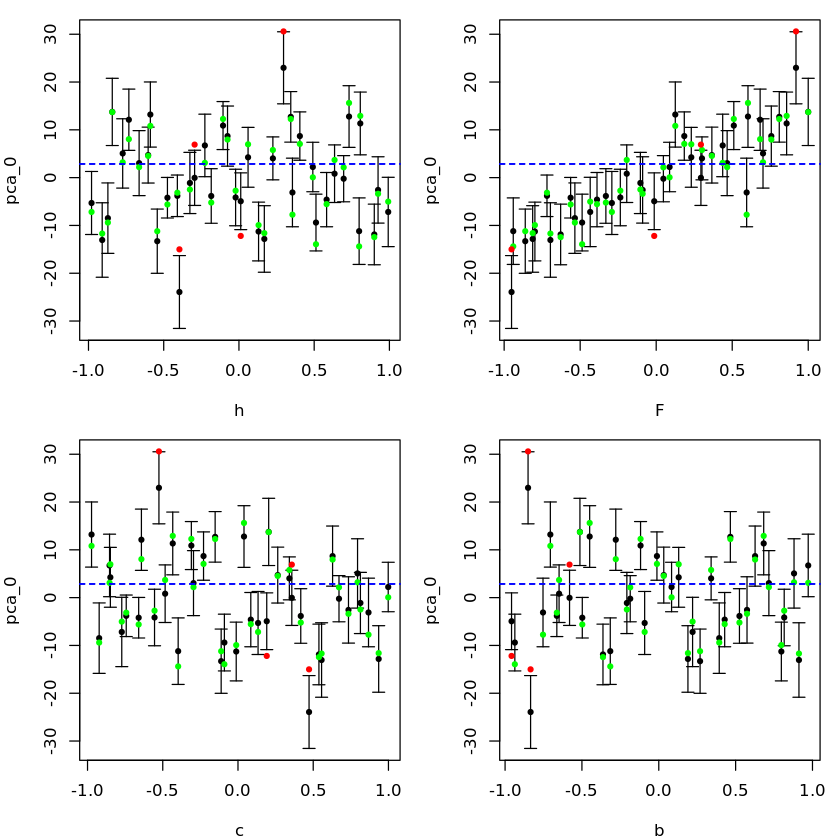

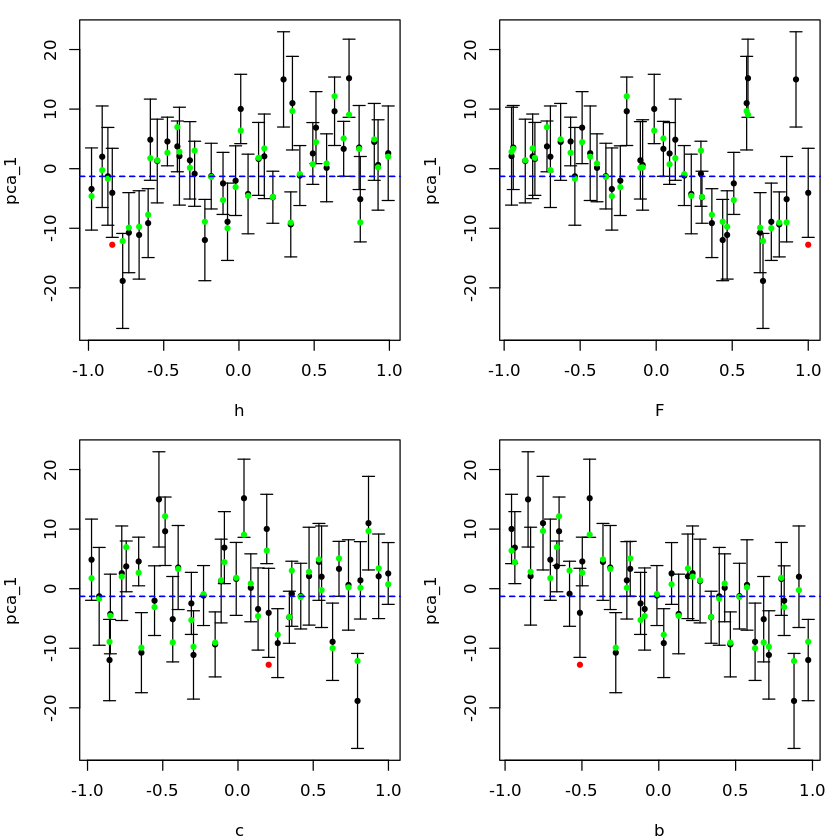

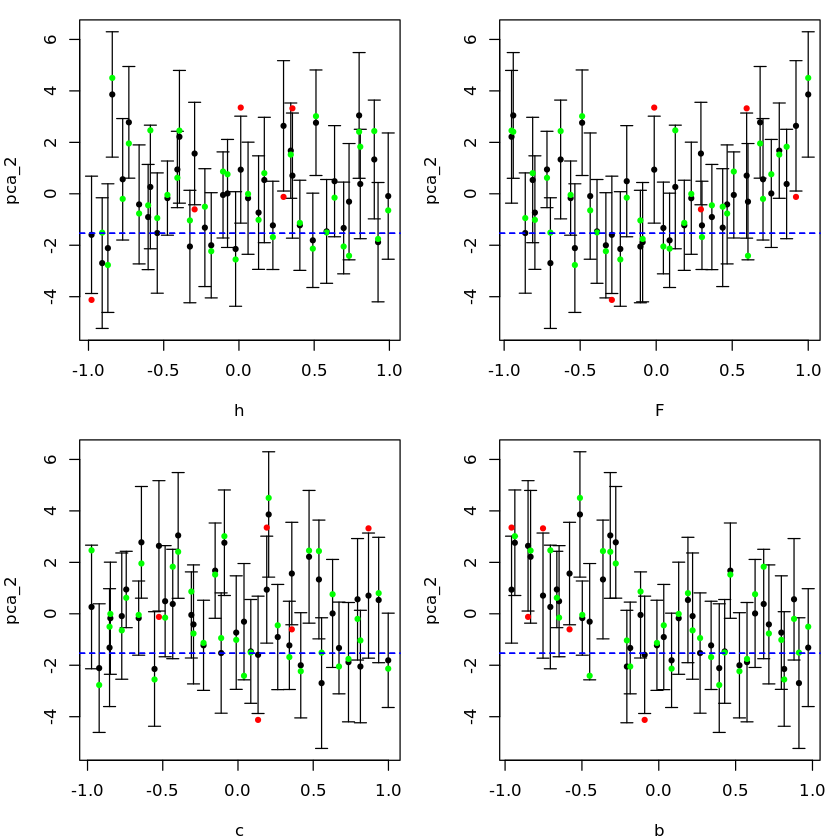

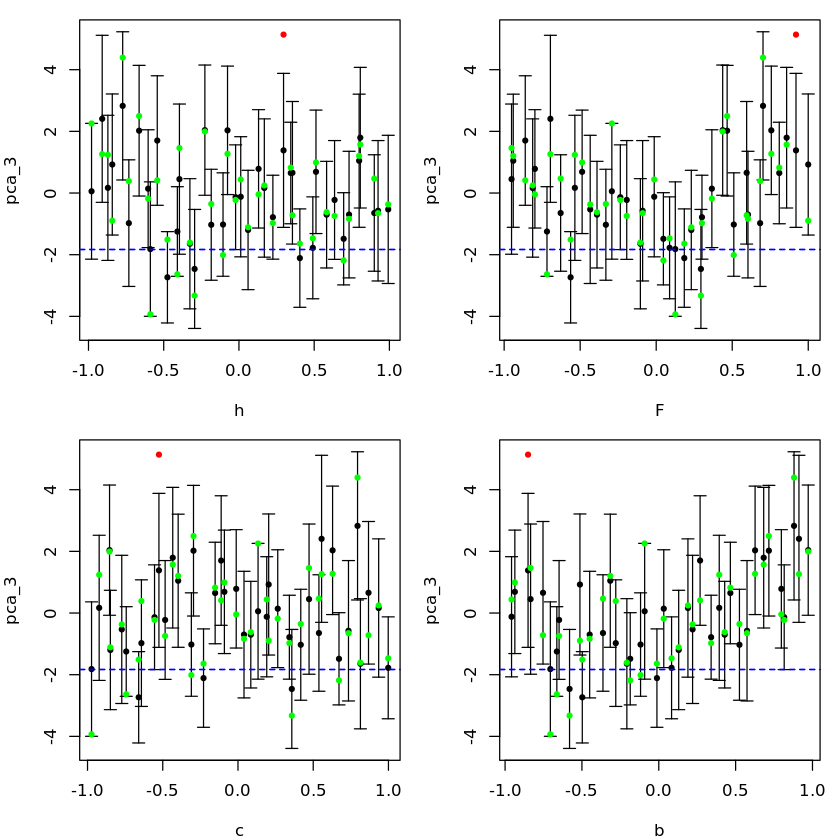

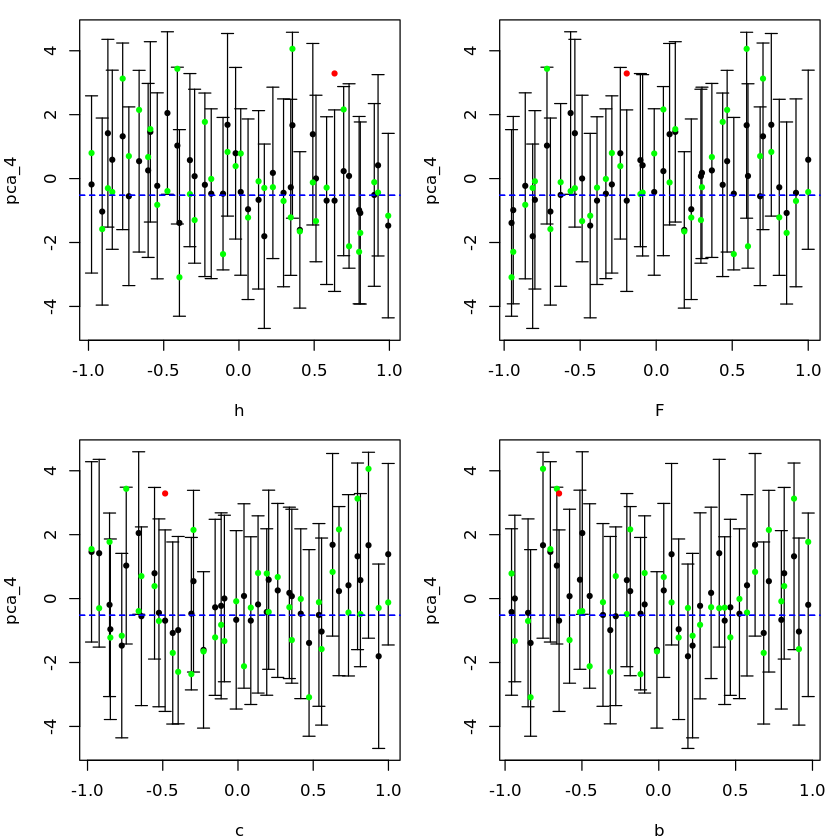

In [10]:
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 3, ParamNames = cands, Obs = tObs[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 4, ParamNames = cands, Obs = tObs[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 5, ParamNames = cands, Obs = tObs[5], ObsErr = 0.)#tLOOs <- 

## History Matching
* Observations discrepancy variances in *tDisc* (here sets to 0)
* Observations errors in *tObsErr* (here set to 0)

In [11]:
future::availableCores() 

Slurm 
   20

In [12]:
set.seed(42)
sample_size <- 1000000
nparam <- length(names(TestEm$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(TestEm$fitting.elements$Design)

In [13]:
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 18.739  11.492   5.085 

In [14]:
ImpData_wave1 = cbind(Xp, Timps)
print(object.size(ImpData_wave1), units="Mb")

68.7 Mb


In [15]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off?
cutoff_vec <- 3 #the implausibility cut off

param.def = data.frame(h=c(1), F=c(10), c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

  h F           c           b
1 0 0 -0.05263158 -0.05263158


In [16]:
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=TestEm$mogp$n_emulators, whichMax=valmax+1)
NROY1 <- which(rowSums(Timps <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
ratio1 <- length(NROY1)/dim(Xp)[1]
ratio1

[1] 0.255731

#### 40 samples for training, 1 000 000 points for test

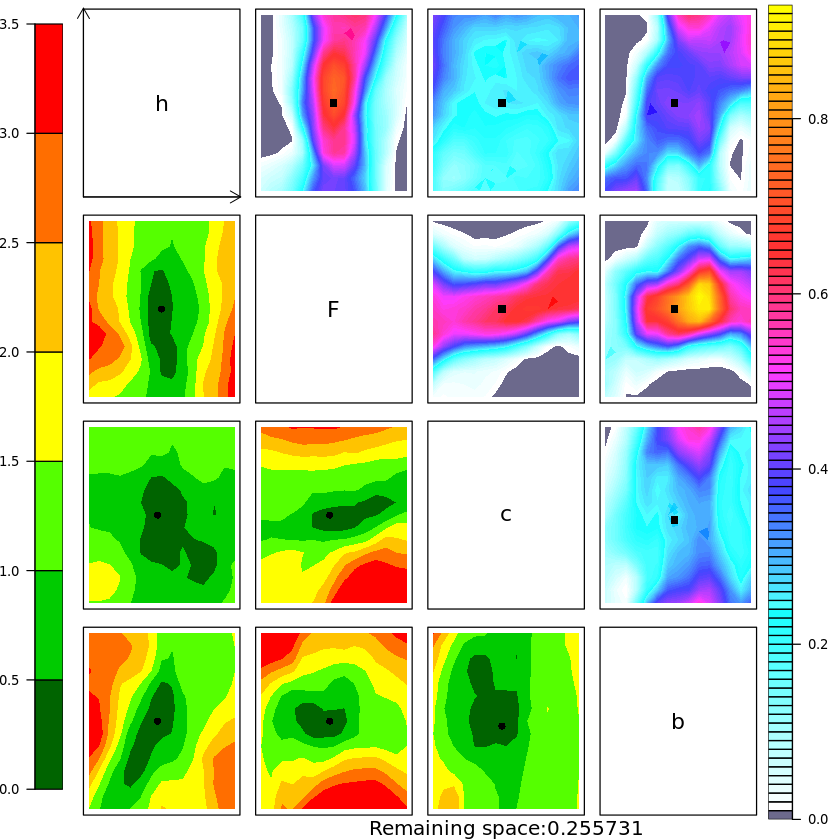

In [17]:
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY1)/dim(Xp)[1],sep=""), side=1)

In [18]:
indminImp <- order(apply(Timps[NROY1,], 1, FUN=max))
rangeUnscale(Xp[NROY1[indminImp[1:100]],], my_bounds)

,h,F,c,b
688704,1.2576889,9.973211,10.709672,11.007388
107103,0.5448344,10.674149,15.416740,7.492420
741921,1.2780829,9.889589,10.179163,10.839390
149202,1.0886827,9.846963,11.004472,10.411268
217813,0.8661486,9.360680,10.152049,9.126773
436583,0.4337229,10.859025,15.519424,6.888281
293335,1.1378929,9.636945,11.334472,10.978092
502165,0.7727952,9.327127,11.004162,8.155156
306680,1.1946918,9.562286,9.750473,10.910835
396048,0.7433388,9.317200,10.071870,7.885081


In [19]:
length(NROY1)

[1] 255731

# Wave2

In [19]:
40/ratio1

[1] 156.4144

In [20]:
set.seed(42)

designpoints <- data.frame()

while (nrow(designpoints) <= 40) {
        tmp <- as.data.frame(2*maximinLHS(ceil(40/ratio1), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        selectionP <- tmp[NROYtmp,]
        row.names(selectionP) <- NULL ## to avoid double index
        designpoints <- rbind(designpoints,selectionP)
        print(nrow(designpoints))
        flush.console()
        } 

designpoints <- designpoints[sample(nrow(designpoints),40),]

designpoints_denorm <- rangeUnscale(designpoints, my_bounds)

[1] 47


In [21]:
designpoints_denorm

,h,F,c,b
6,1.28964143,11.854978,12.741437,12.674857
31,0.01944759,8.165050,19.757955,9.670599
23,1.36360342,6.766776,6.983383,18.653007
10,0.92660462,8.757895,16.058709,5.461294
11,0.91582362,13.266182,9.702212,14.320167
13,1.14021912,15.454072,16.940174,6.177231
14,0.95553505,11.374741,12.467332,8.925073
38,1.30036691,10.034730,17.924207,11.529042
47,1.20451421,10.213341,3.046712,15.473119
43,0.55259659,9.573872,17.665088,15.185457


In [22]:
write.csv(designpoints_denorm,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave2.csv", row.names = FALSE)

In [23]:
inputs <- designpoints

#Load outputs and select variables you want to keep
outputs <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave2.csv")
                         
#Add some noise (here no noise added)
set.seed(42)

N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4
6,0.28964143,0.1854978,0.23594076,0.22893233,0.68547922,4.8418942,-3.073250,-1.7846739,-1.3102134,-0.42261514
31,-0.98055241,-0.1834950,0.97452162,-0.08730539,-0.28234909,-6.4069105,-5.422896,-3.9671237,2.6195711,1.24437996
23,0.36360342,-0.3233224,-0.37017021,0.85821124,0.18156421,-4.1559692,-1.550541,-2.2360357,-0.2715580,0.05312133
10,-0.07339538,-0.1242105,0.58512723,-0.53039014,0.31643130,0.6306411,6.475282,-0.8236635,-2.8356508,3.39273912
11,-0.08417638,0.3266182,-0.08397769,0.40212286,0.20213416,5.0123568,-6.536052,-0.7080026,-0.1296571,0.15977472
13,0.14021912,0.5454072,0.67791308,-0.45502829,-0.05306226,10.8820886,4.544147,-2.0421568,-3.0063841,-0.53456001


In [24]:
TestEm2 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 2.37543724360361 using F"
[1] "Max reduction is 0.141587672809496 using b"
[1] "Max reduction is 0.266530177833769 using h"
[1] "Max reduction is 0.289880875220958 using c"
[1] "Max reduction is 0.254737988491677 using h"
[1] "Max reduction is 0.334393435912907 using Three Way Interactions with h"
[1] "Max reduction is 0.0776909676939672 using b"
[1] "Max reduction is 0.147592497765506 using Three Way Interactions with b"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ F + b + I(b^2) + h + I(h^2) + c + I(b * 
    F) + I(h * F) + I(c * F) + I(h * b) + I(c * b) + I(c * h) + 
    I(h * b * F) + I(h * h * F) + I(h * c * F) + I(h * h * b) + 
    I(h * c * b) + I(h * c * h) + I(b * b * F) + I(b * c * F) + 
    I(b * h * b) + I(b * c * b), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32322 -0.29352  0.00108  0.22317  1.39896 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(

In [25]:
tObs2 <- read.csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_obs_nonoise_newPCA_PhysPrior_wave1.csv")
tObs2 <- as.vector(t(tObs2)) ############## no chnage in obs in waves

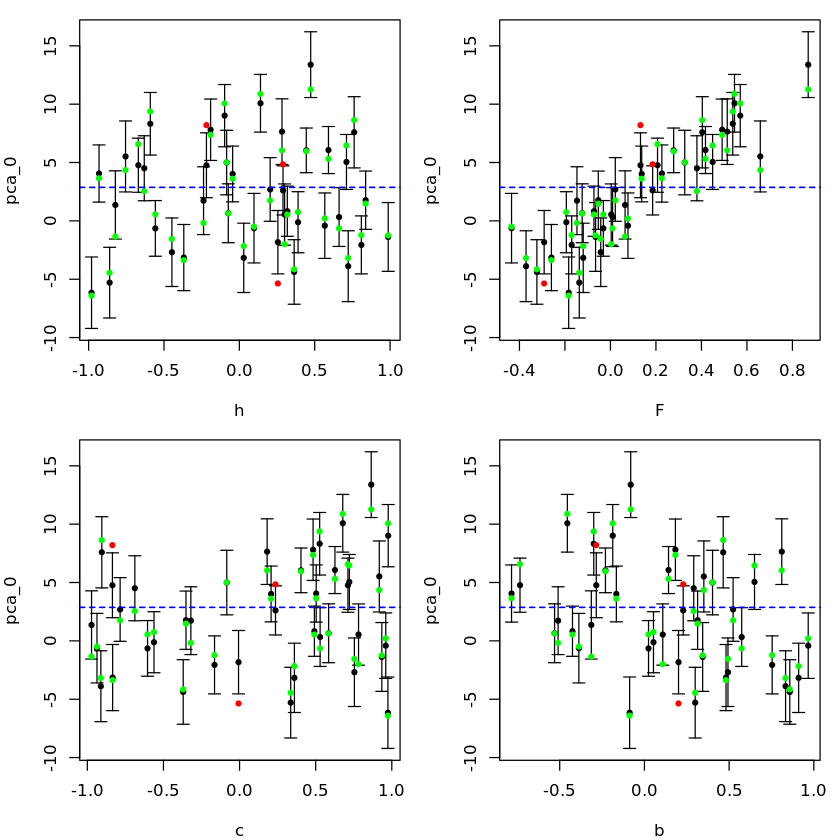

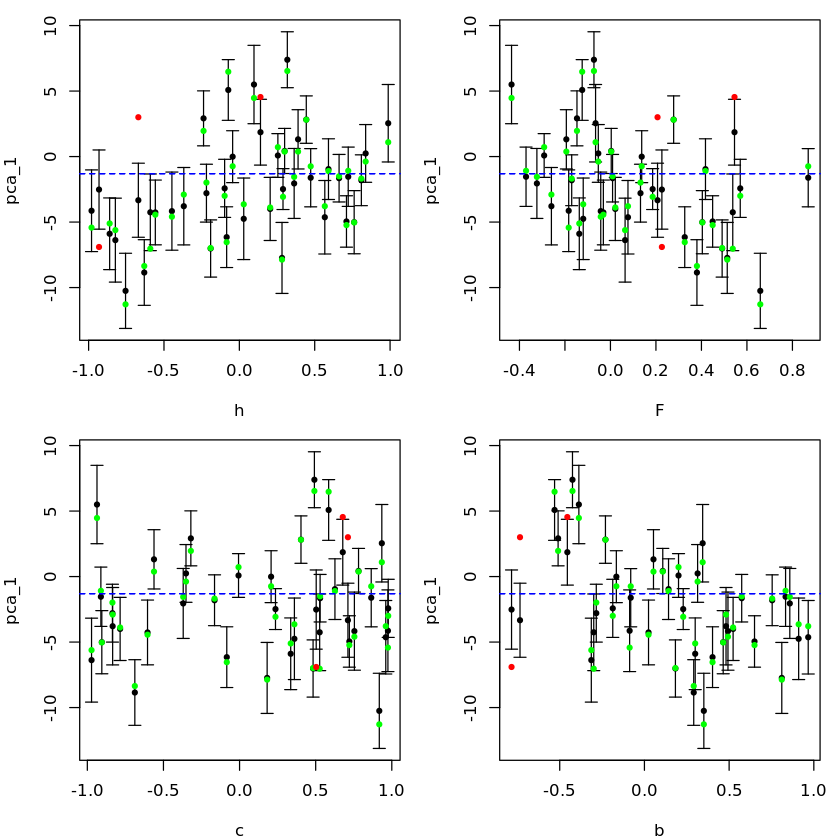

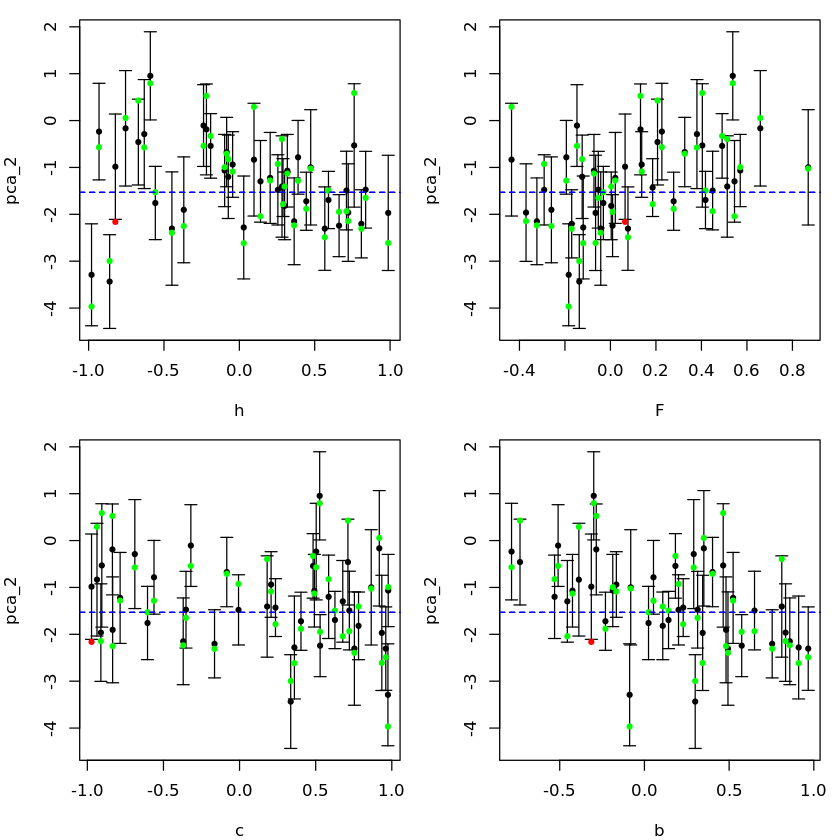

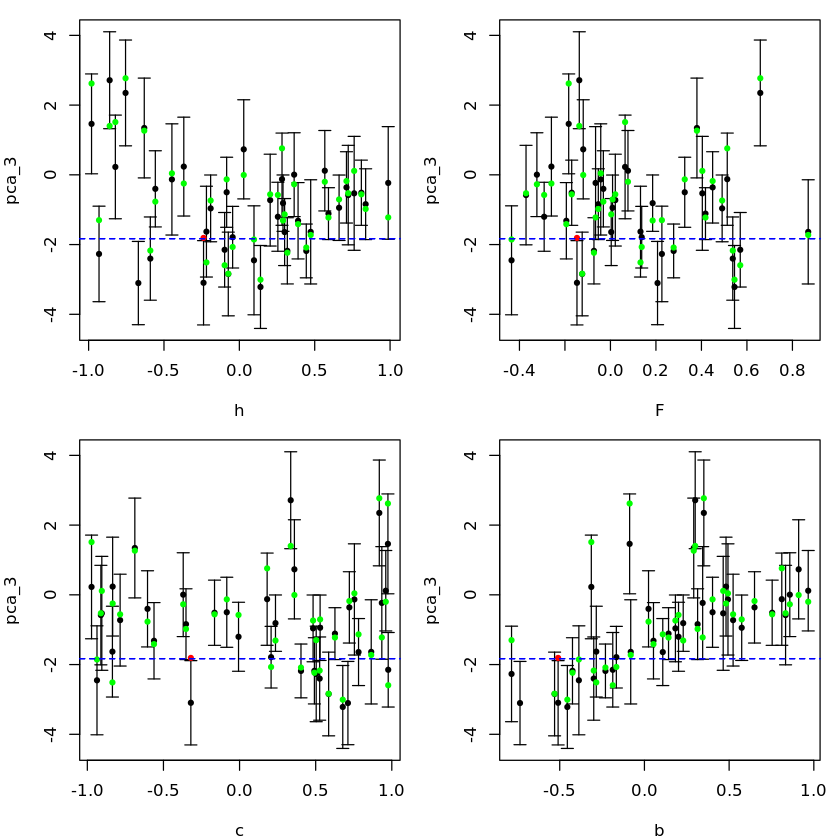

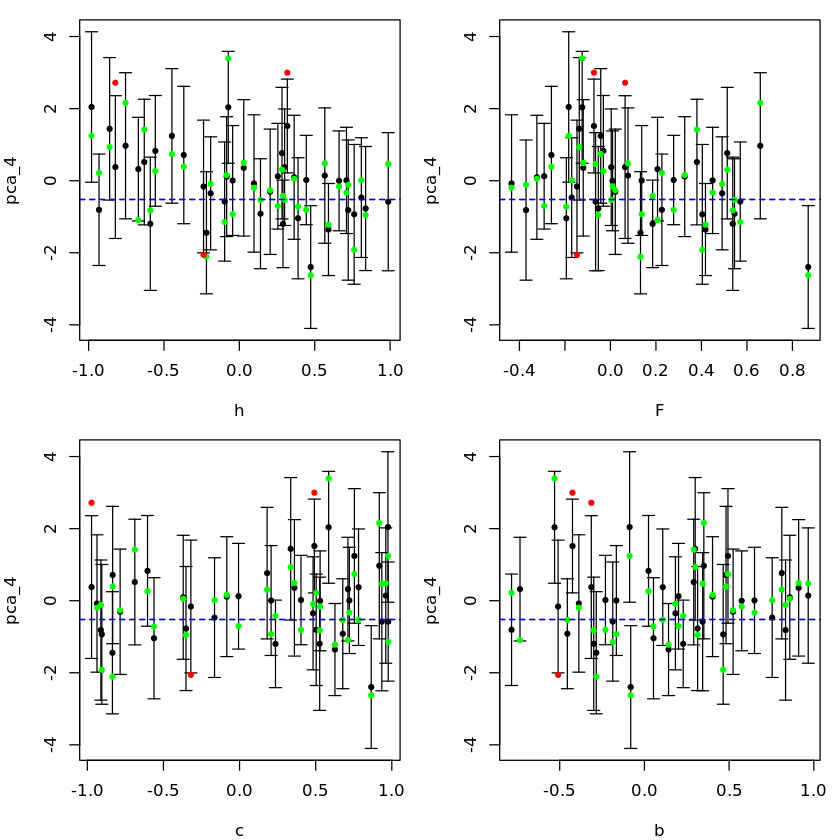

In [26]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [27]:
Timps2 <- matrix(rep(t(Timps),1), ncol=ncol(Timps), byrow=TRUE)
system.time(Timps2[NROY1,] <- ImplausibilityMOGP(NewData=Xp[NROY1,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs2, ObsErr=tObsErr))

   user  system elapsed 
  6.341   8.781   2.508 

In [28]:
#tracemem(Timps2) == tracemem(Timps)

In [29]:
ImpData_wave2 = cbind(Xp, Timps2)

In [30]:
valmax2 = 0 #how many outputs can be above the implausibility cut off?
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=TestEm2$mogp$n_emulators, whichMax=valmax2+1)
NROY2 <- which(rowSums(Timps2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax2)
ratio2 <- length(NROY2)/dim(Xp)[1]
ratio2

[1] 0.031812

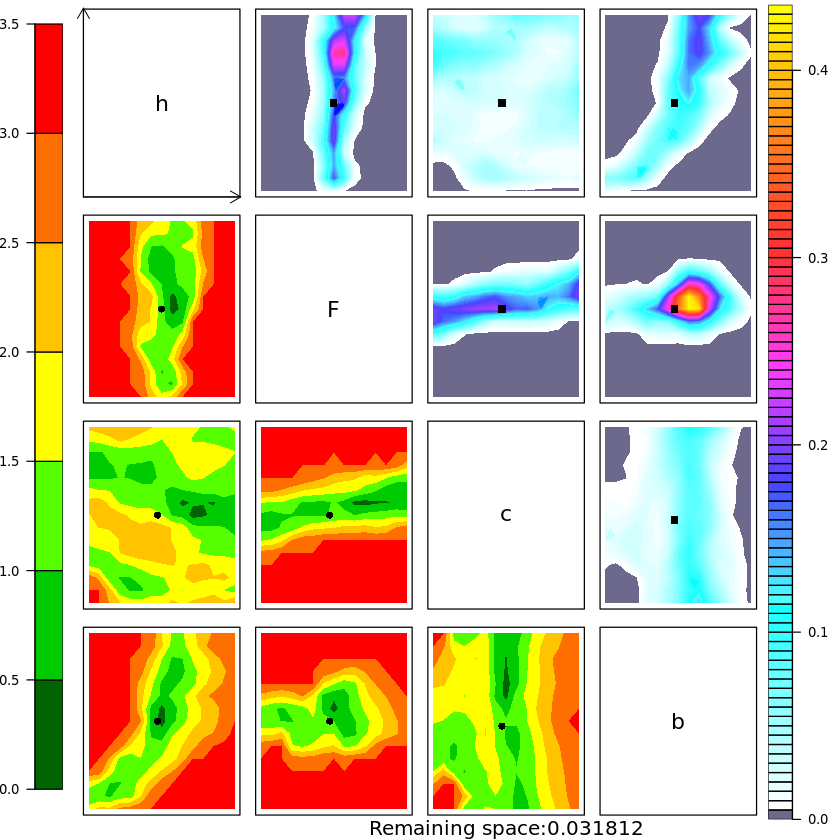

In [31]:
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY2)/dim(Xp)[1],sep=""), side=1)

In [32]:
indminImp2 <- order(apply(Timps2[NROY2,], 1, FUN=max))
rangeUnscale(Xp[NROY2[indminImp2[1:10]],], my_bounds)

,h,F,c,b
36508,1.056688,11.11882,13.69855,10.38706
864936,1.093024,11.11962,13.59558,10.54167
528471,1.065250,11.12748,13.96778,10.20147
488125,1.044284,11.08972,13.75624,10.56768
675630,1.066374,11.62818,15.21913,10.52878
114652,1.008003,11.12094,14.70947,10.43206
926709,1.068915,11.54441,16.20800,10.73352
308841,1.081206,11.67320,15.51466,10.29161
376273,1.073495,11.42445,15.24748,10.87851
508267,1.101350,11.02624,12.90643,10.54169


In [33]:
length(NROY2)

[1] 31812

# Wave 3

In [34]:
40/ratio2

[1] 1257.387

In [35]:
set.seed(42)

designpoints2 <- data.frame()

while (nrow(designpoints2) <= 40) { 
        ### Emulator wave 1
        tmp <- as.data.frame(2*maximinLHS(ceil(40/ratio2), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs2, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints2 <- rbind(designpoints2,selectionP)
        print(nrow(designpoints2))
        flush.console()
        } 

designpoints2 <- designpoints2[sample(nrow(designpoints2),40),]

designpoints_denorm2 <- rangeUnscale(designpoints2, my_bounds)

[1] 41


In [36]:
designpoints_denorm2

,h,F,c,b
27,1.6262770,12.681315,7.604530,13.732423
19,0.7118176,9.142802,13.966199,7.315658
12,1.7134744,13.631569,18.089063,11.628335
4,1.6101462,9.602840,7.352768,17.326021
24,0.8280480,11.046253,17.980656,12.762127
33,1.9893214,9.709105,11.650308,14.639706
32,0.4662600,10.574708,5.781078,4.898476
6,1.1787687,9.627556,5.551630,12.485608
7,1.5109925,12.232203,5.033509,12.929465
38,1.6927291,12.979854,13.473948,13.188067


In [37]:
write.csv(designpoints_denorm2,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave3.csv", row.names = FALSE)

In [38]:
inputs <- designpoints2

#Load outputs and select variables you want to keep
outputs <- read.csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave3.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4
27,0.6262770,0.26813147,-0.3047863,0.3402551,0.68547922,7.1767460,-3.5856759,-1.154674,-0.6929050,-1.28482568
19,-0.2881824,-0.08571981,0.3648631,-0.3351939,-0.28234909,-1.3308315,1.4034950,-0.515228,-2.0616176,-0.53450659
12,0.7134744,0.36315692,0.7988487,0.1187721,0.18156421,2.1956844,0.5488190,-1.489286,-1.2034998,-1.21273504
4,0.6101462,-0.03971599,-0.3312876,0.7185286,0.31643130,0.6218415,-2.9848232,-2.042256,-0.4524787,-0.07763272
24,-0.1719520,0.10462528,0.7874375,0.2381186,0.20213416,1.9222872,-4.0745323,-2.017125,-1.0082459,0.39628732
33,0.9893214,-0.02908949,0.1210850,0.4357585,-0.05306226,-2.3732727,0.4898018,-1.111304,-0.5597041,-1.04867590


In [39]:
TestEm3 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.174604867042173 using b"
[1] "Max reduction is 0.269935785369564 using F"
[1] "Max reduction is 0.956819083032575 using c"
[1] "Max reduction is 0.294566204070801 using h"
[1] "Max reduction is 0.32443676985242 using b"
[1] "Max reduction is 0.054867047080847 using Three Way Interactions with b"
[1] "Max reduction is 0.0834883373652355 using b"
[1] "Max reduction is 0.0012140263450553 using h"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = pca_0 ~ b + I(b^2) + I(b^3) + F + c + h + I(h^2) + 
    I(F * b) + I(c * b) + I(h * b) + I(c * F) + I(h * F) + I(h * 
    c) + I(b * F * b) + I(b * c * b) + I(b * h * b) + I(b * c * 
    F) + I(b * h * F) + I(b * h * c), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.73921 -0.32939 -0.05354  0.29618  1.83263 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.7629     0.3629   4.857 9.55e-05 ***
b              1.1349     1.83

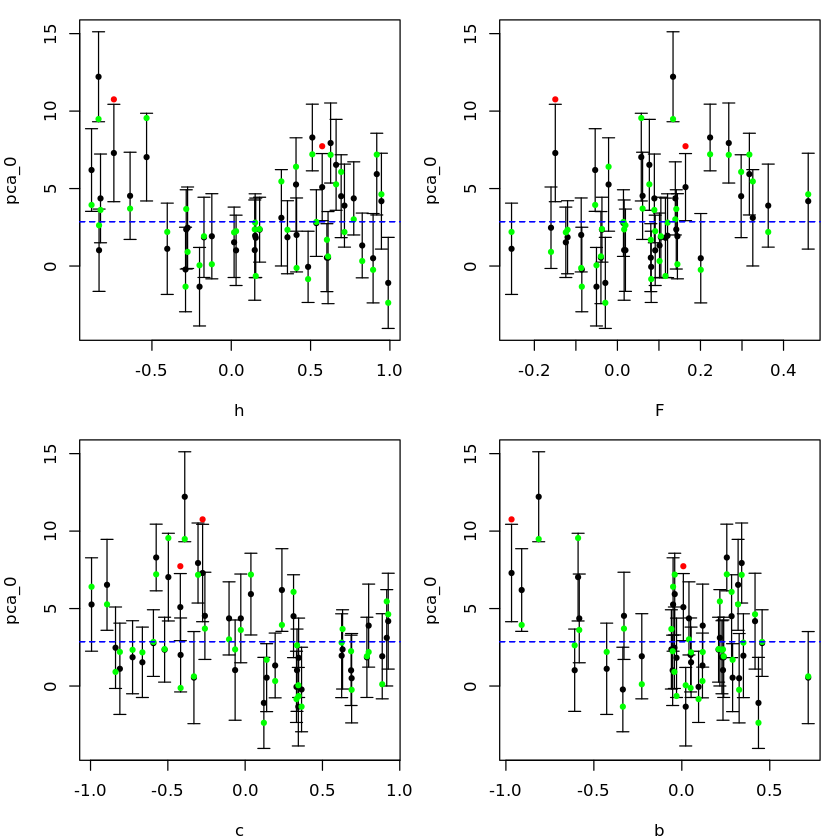

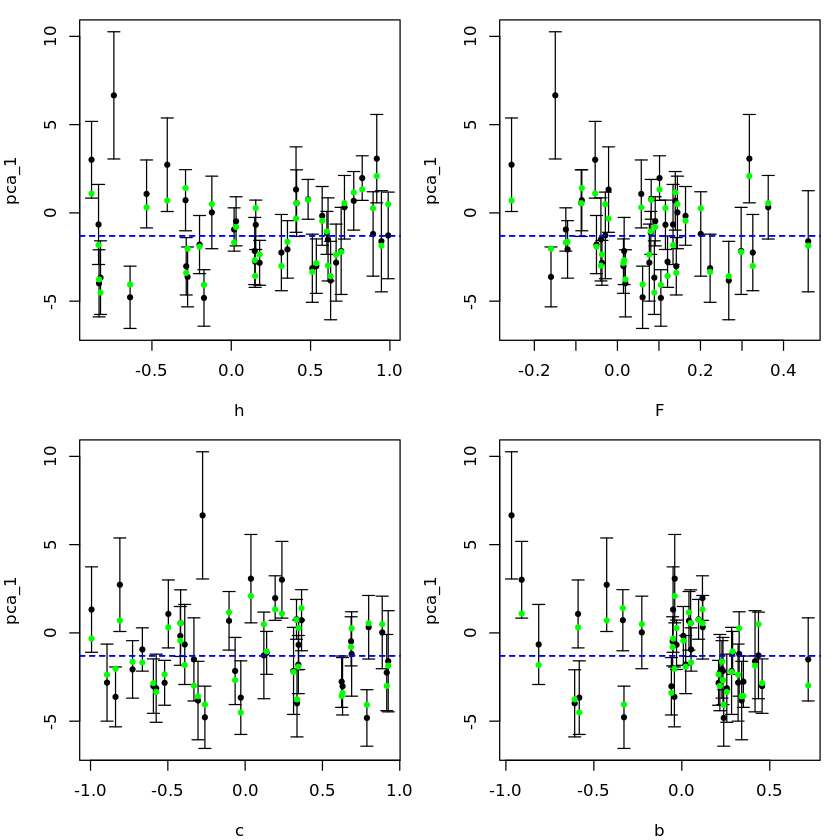

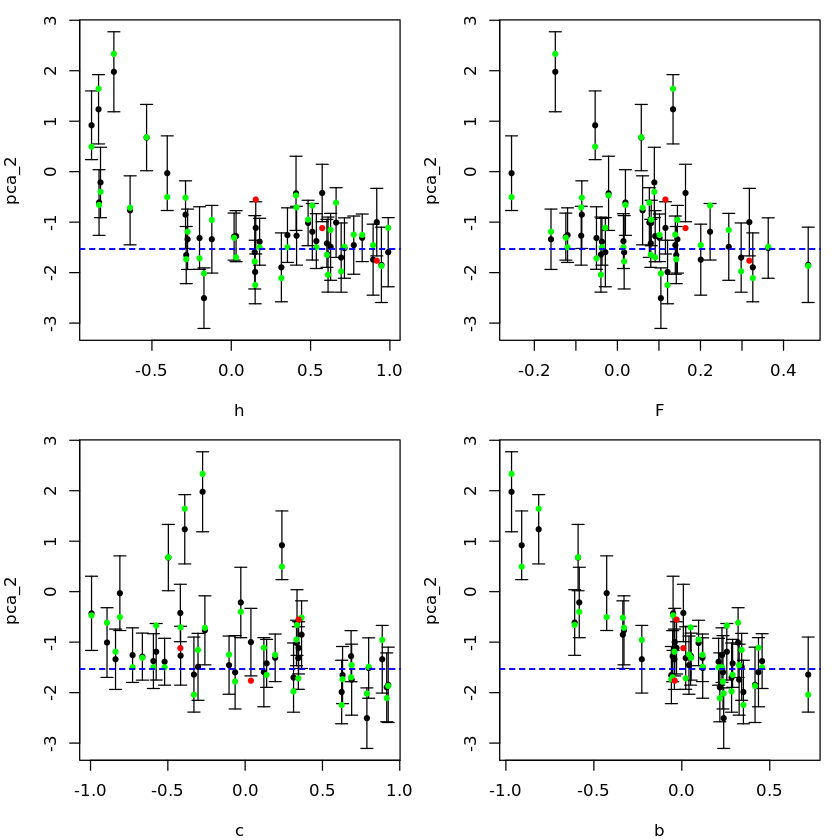

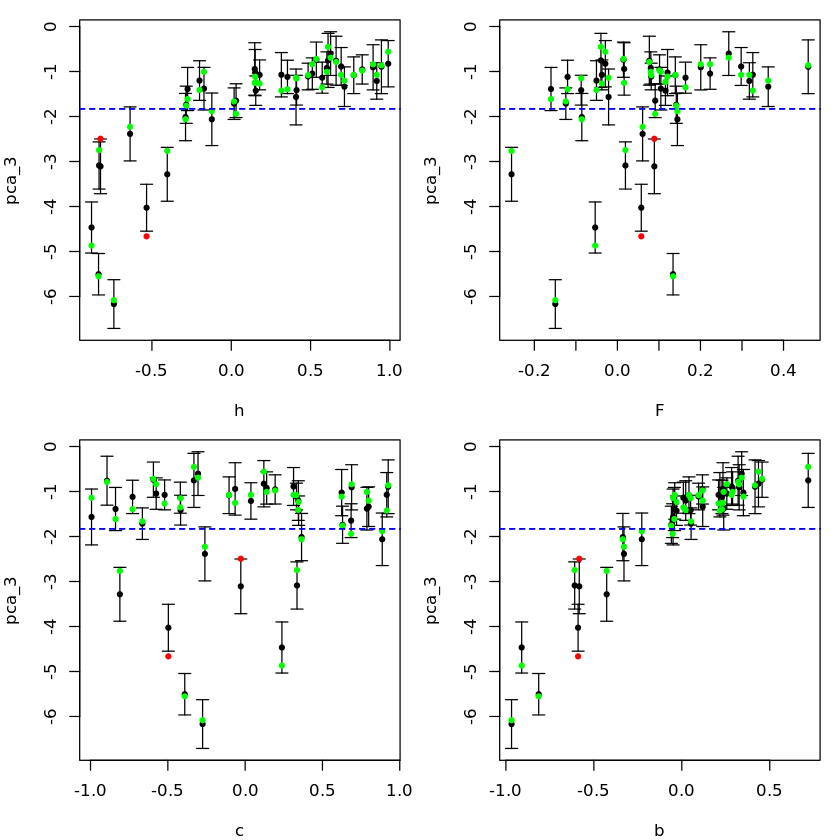

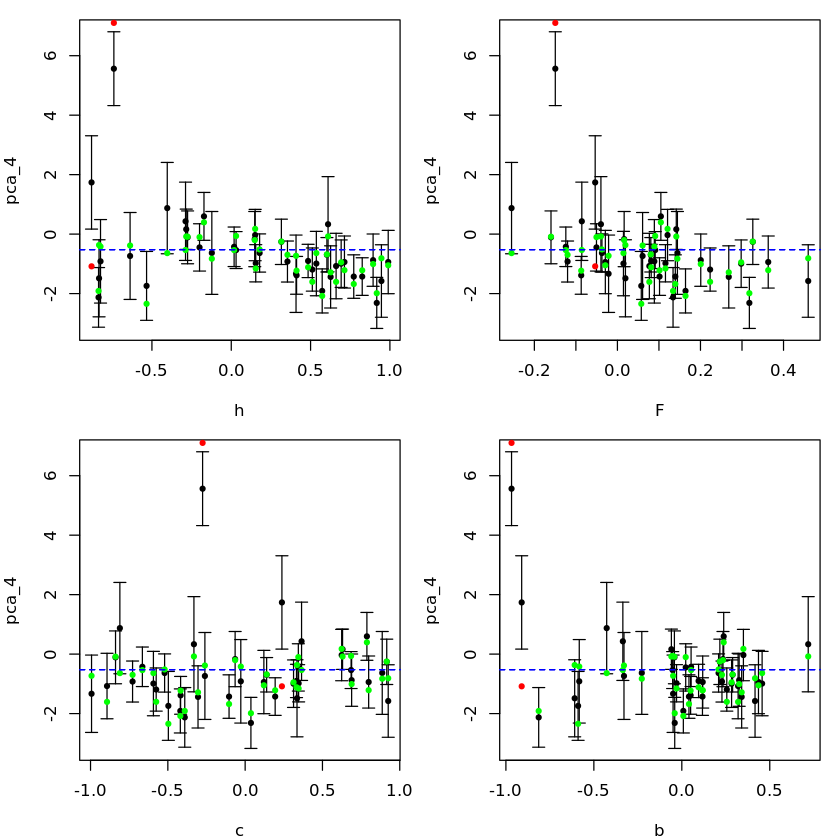

In [40]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [41]:
Timps3 <- matrix(rep(t(Timps2),1), ncol=ncol(Timps2), byrow=TRUE)
system.time(Timps3[NROY2,] <- ImplausibilityMOGP(NewData=Xp[NROY2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  1.553   5.043   1.618 

In [42]:
ImpData_wave3 = cbind(Xp, Timps3)

In [43]:
valmax3 = 0 #how many outputs can be above the implausibility cut off?
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=TestEm3$mogp$n_emulators, whichMax=valmax3+1)
NROY3 <- which(rowSums(Timps3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax3)
ratio3 <- length(NROY3)/dim(Xp)[1]
ratio3

[1] 0.00589

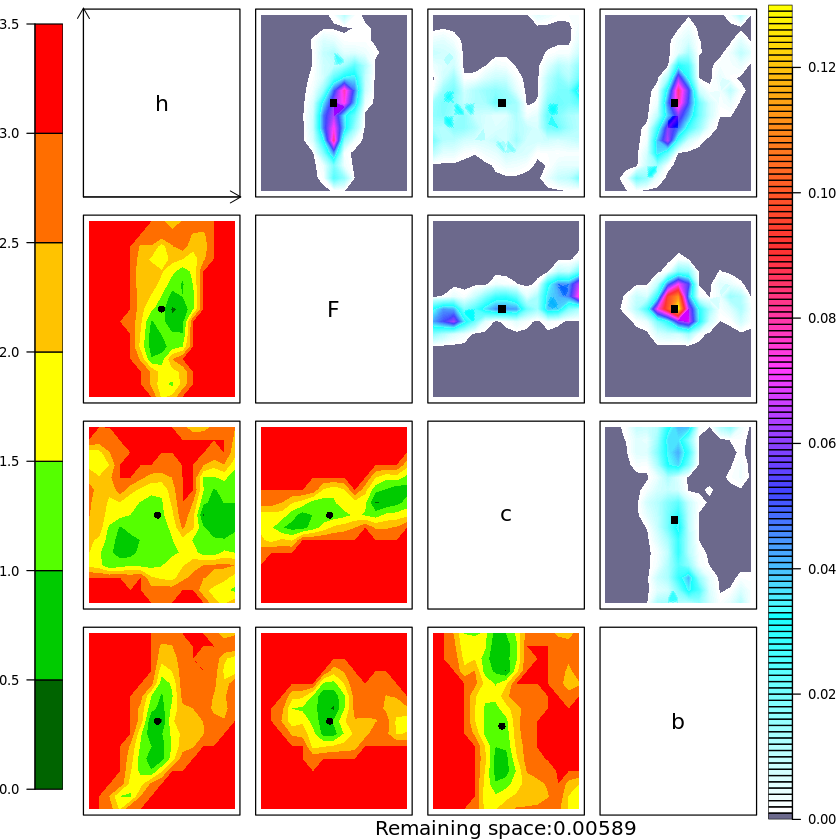

In [44]:
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY3)/dim(Xp)[1],sep=""), side=1)

In [45]:
length(NROY3)

[1] 5890

## wave 4

In [46]:
40/ratio3

[1] 6791.171

switch to randomLHS

In [48]:
set.seed(42)

designpoints3 <- data.frame()

while (nrow(designpoints3) <= 40) { 
        ### Emulator wave 1
        tmp <- as.data.frame(2*randomLHS(ceil(40/ratio3), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints3 <- rbind(designpoints3,selectionP)
        print(nrow(designpoints3))
        flush.console()
        } 

designpoints3 <- designpoints3[sample(nrow(designpoints3),40),]

designpoints_denorm3 <- rangeUnscale(designpoints3, my_bounds)

[1] 38
[1] 74


In [49]:
write.csv(designpoints_denorm3,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave4.csv", row.names = FALSE)

In [50]:
designpoints3

,h,F,c,b
46,-0.088883705,0.017322376,-0.78135058,0.30272774
3,0.011886523,0.115362182,-0.21866132,-0.15552112
29,-0.205891733,0.278400769,0.88358393,-0.12685823
49,-0.315945830,-0.068230065,-0.90248064,0.07802248
66,0.370382555,0.235363071,0.51362517,-0.04196303
72,0.138066841,0.198386830,0.98064862,0.51175937
4,0.058863666,0.317184256,0.90568924,-0.01148172
36,0.019299174,0.190084645,0.96105700,0.60968899
13,-0.408141552,-0.146803268,-0.99150631,-0.08870328
28,0.152928211,0.083690755,-0.12076296,0.04663691


In [51]:
inputs <- designpoints3

#Load outputs and select variables you want to keep
outputs <- read.csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave4.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4
46,-0.08888370,0.01732238,-0.7813506,0.30272774,0.68547922,2.1897305,-4.1153665,-1.204344,-0.8044648,-0.1235898
3,0.01188652,0.11536218,-0.2186613,-0.15552112,-0.28234909,6.1668736,-1.1960135,-1.002997,-2.2110588,-1.3146446
29,-0.20589173,0.27840077,0.8835839,-0.12685823,0.18156421,5.5224137,-2.9068709,-1.424775,-2.2226744,-0.3160798
49,-0.31594583,-0.06823006,-0.9024806,0.07802248,0.31643130,0.6182055,-3.2150400,-1.256367,-0.8514099,0.5695557
66,0.37038256,0.23536307,0.5136252,-0.04196303,0.20213416,1.2765685,0.8714935,-0.961259,-1.4427340,-1.2856235
72,0.13806684,0.19838683,0.9806486,0.51175937,-0.05306226,2.3433992,-4.3853334,-2.127503,-0.6718112,0.3144345


In [52]:
TestEm4 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.347226633669319 using F"
[1] "Max reduction is 0.37269041029522 using c"
[1] "Max reduction is 0.183732274280872 using h"
[1] "Max reduction is 0.170625282986707 using b"
[1] "Max reduction is 0.108650026760069 using F"
[1] "Max reduction is 0.148935136773679 using Three Way Interactions with F"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ F + I(F^2) + c + h + b + I(c * F) + I(h * 
    F) + I(b * F) + I(h * c) + I(b * c) + I(b * h) + I(F * c * 
    F) + I(F * h * F) + I(F * b * F) + I(F * h * c) + I(F * b * 
    c) + I(F * b * h), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.21194 -0.42710 -0.00709  0.35665  0.84724 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1.8561     0.2774   6.691 1.00e-06 ***
F              23.6470     4.6022   5.138 3.77e-05 ***
I(F^2)         16.7183    21.8476   0.765 0.452269    
c              -4.8880     0.8252  -5.923 5.83e-06 ***
h        

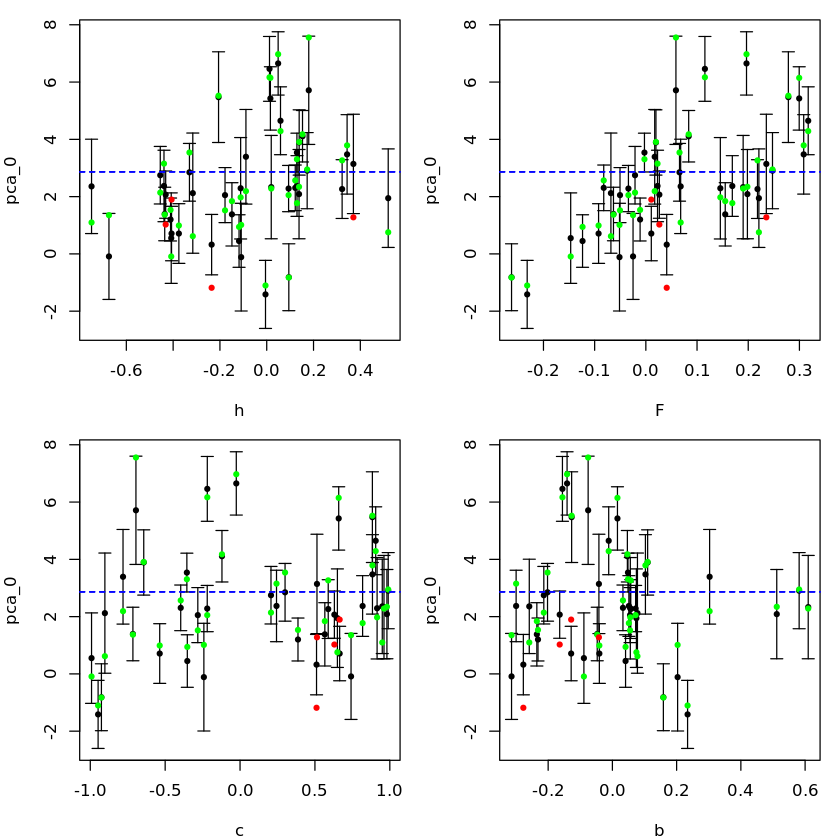

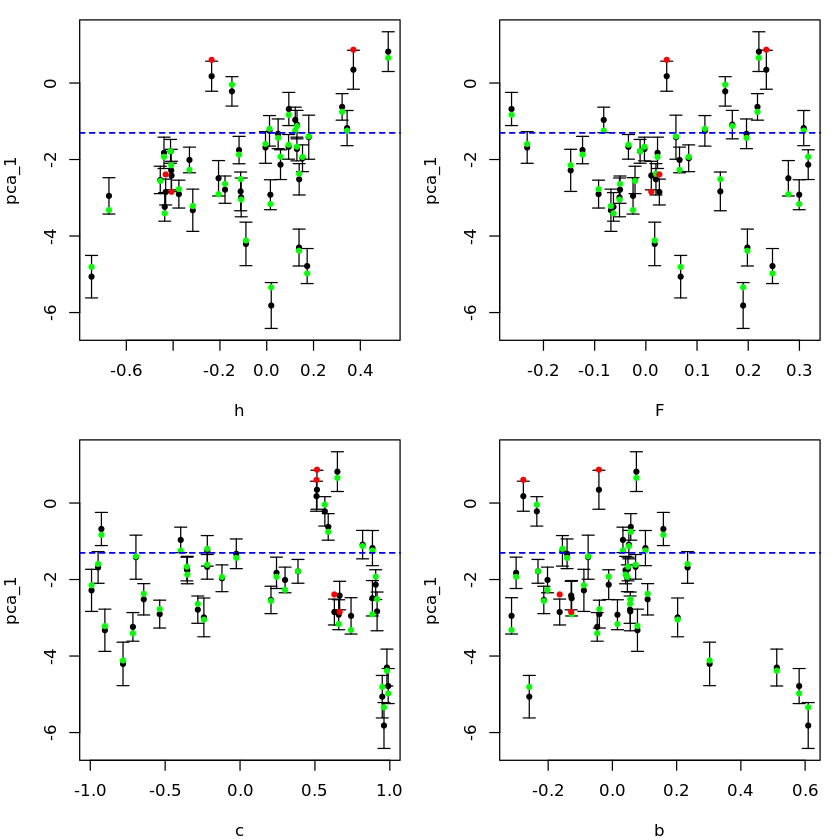

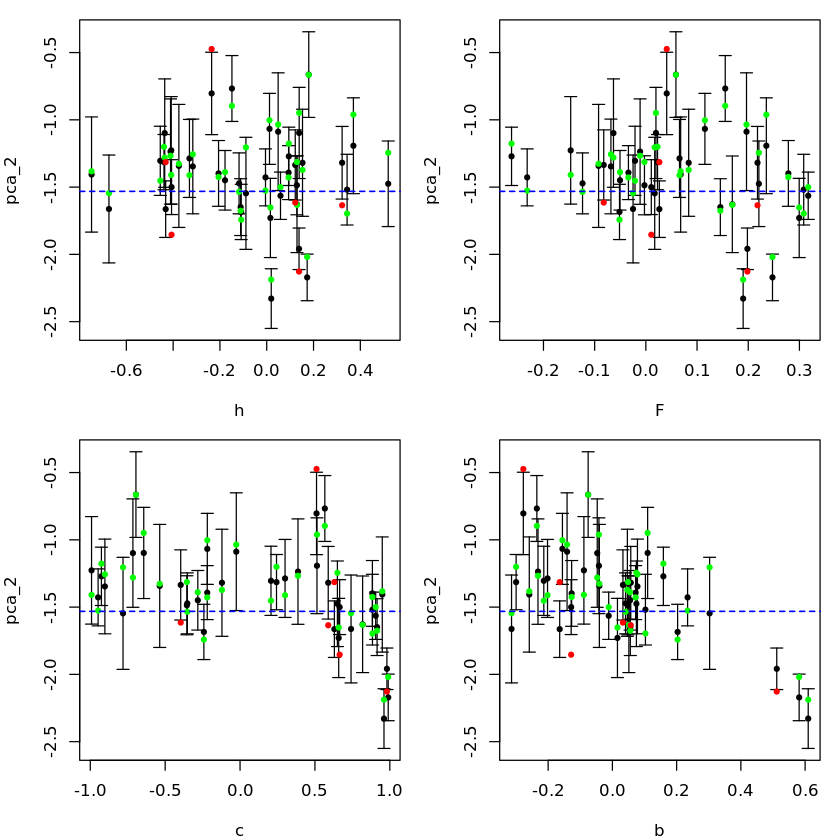

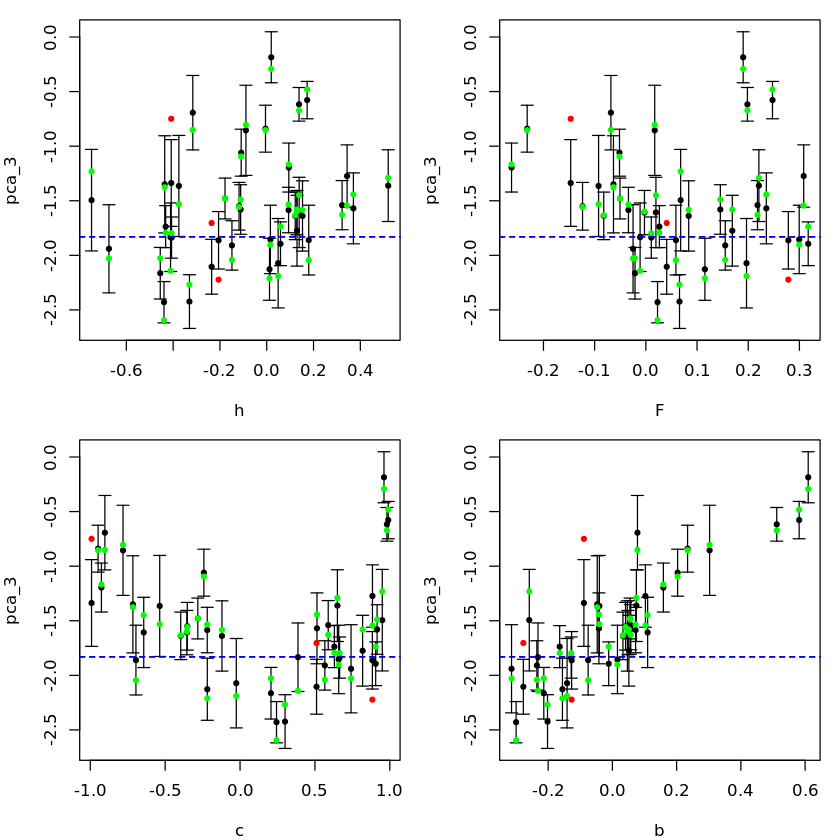

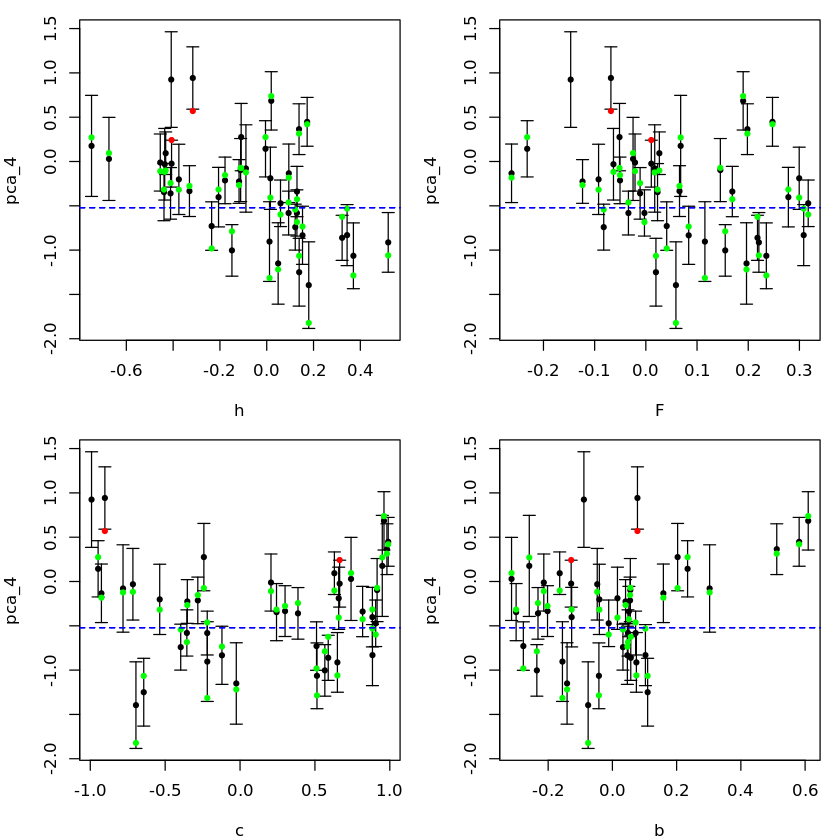

In [53]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [54]:
Timps4 <- matrix(rep(t(Timps3),1), ncol=ncol(Timps3), byrow=TRUE)
system.time(Timps4[NROY3,] <- ImplausibilityMOGP(NewData=Xp[NROY3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.870   4.121   1.549 

In [55]:
ImpData_wave4 = cbind(Xp, Timps4)

In [56]:
valmax4 = 0 #how many outputs can be above the implausibility cut off?
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=TestEm4$mogp$n_emulators, whichMax=valmax4+1)
NROY4 <- which(rowSums(Timps4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax4)
ratio4 <- length(NROY4)/dim(Xp)[1]
ratio4

[1] 0.000379

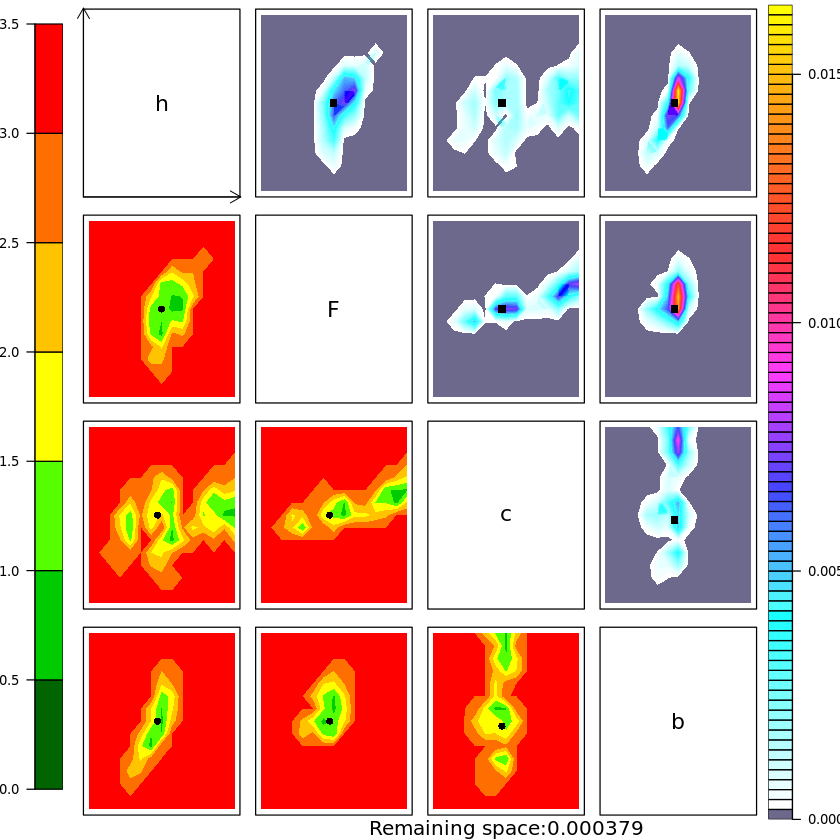

In [57]:
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY4)/dim(Xp)[1],sep=""), side=1)

In [58]:
length(NROY4)

[1] 379

## wave 5

In [59]:
40/ratio4 

[1] 105540.9

In [60]:
set.seed(42)

designpoints4 <- data.frame()

while (nrow(designpoints4) <= 40) {
        ### Emulator wave 1
        tmp <- as.data.frame(2*randomLHS(ceil(40/ratio4), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        ### Emulator wave 4
        imps_tmp4 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp4 <- which(rowSums(imps_tmp4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints4 <- rbind(designpoints4,selectionP)
        print(nrow(designpoints4))
        flush.console()
        } 

designpoints4 <- designpoints4[sample(nrow(designpoints4),40),]

designpoints_denorm4 <- rangeUnscale(designpoints4, my_bounds)

[1] 37
[1] 80


In [61]:
write.csv(designpoints_denorm4,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave5.csv", row.names = FALSE)

In [62]:
inputs <- designpoints4

#Load outputs and select variables you want to keep
outputs <- read.csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave5.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4
80,-0.1611008,0.08976304,0.76887577,-0.099225122,0.68547922,1.074241,-1.1704916,-1.456350,-1.745516,-0.3727466
78,0.3696636,0.36655593,0.99257480,0.066266201,-0.28234909,2.072487,-0.3478966,-1.211737,-1.425163,-1.0163178
77,0.1321319,0.07662560,0.03251055,0.005722887,0.18156421,4.011929,-1.5348509,-1.556514,-1.773345,-0.5314149
79,-0.5380369,-0.01215882,0.10616843,-0.380817699,0.31643130,3.611551,-2.0249775,-1.052862,-2.869813,-0.4258052
36,-0.0521931,0.13104705,0.73894888,-0.021508758,0.20213416,1.106219,-1.2736884,-1.282860,-1.557899,-0.4881075
58,-0.4279352,-0.06139914,0.09130374,-0.289891865,-0.05306226,2.557008,-1.5928766,-1.443207,-2.448891,-0.2564091


In [63]:
TestEm5 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.059708140987824 using h"
[1] "Max reduction is 0.246398205629015 using h"
[1] "Max reduction is 0.0411454697062676 using c"
[1] "Max reduction is 0.267040421577741 using F"
[1] "Max reduction is 0.00896591566638061 using h"
[1] "Max reduction is 0.00774352948226598 using Three Way Interactions with h"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ h + I(h^2) + I(h^3) + c + F + I(c * h) + 
    I(F * h) + I(F * c) + I(h * c * h) + I(h * F * h) + I(h * 
    F * c), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.19838 -0.27994  0.08303  0.38445  1.35690 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.5096     0.3272   7.670 2.35e-08 ***
h             -2.6641     1.9337  -1.378  0.17920    
I(h^2)       -19.9868    13.4187  -1.489  0.14754    
I(h^3)       -36.7832    23.1171  -1.591  0.12280    
c             -4.0024     1.2131  -3.299  0.00265 ** 
F             18.3872     5.8104

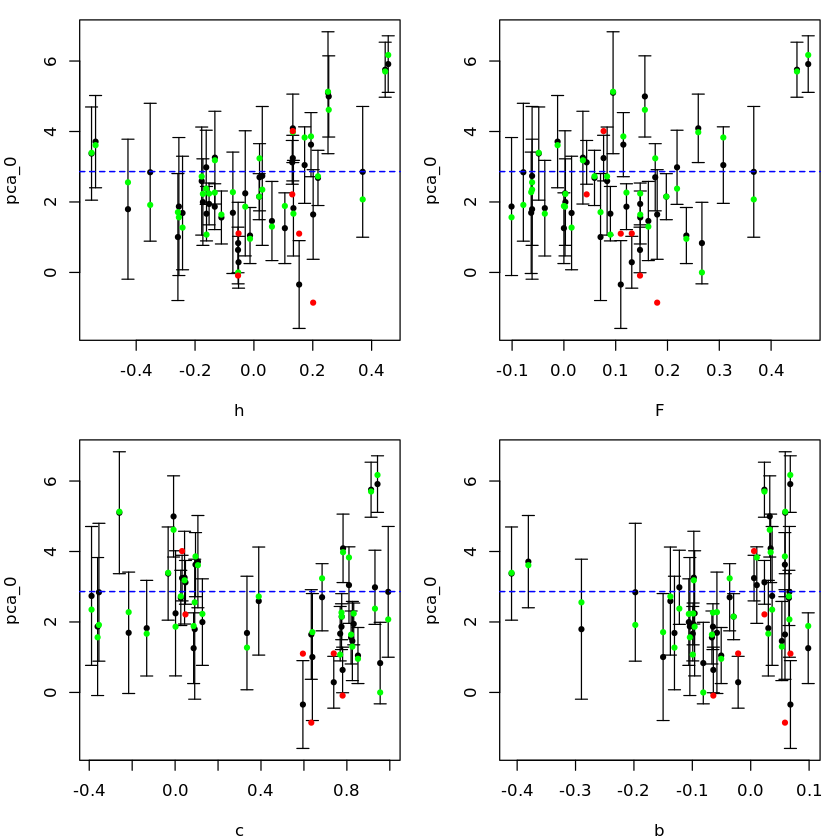

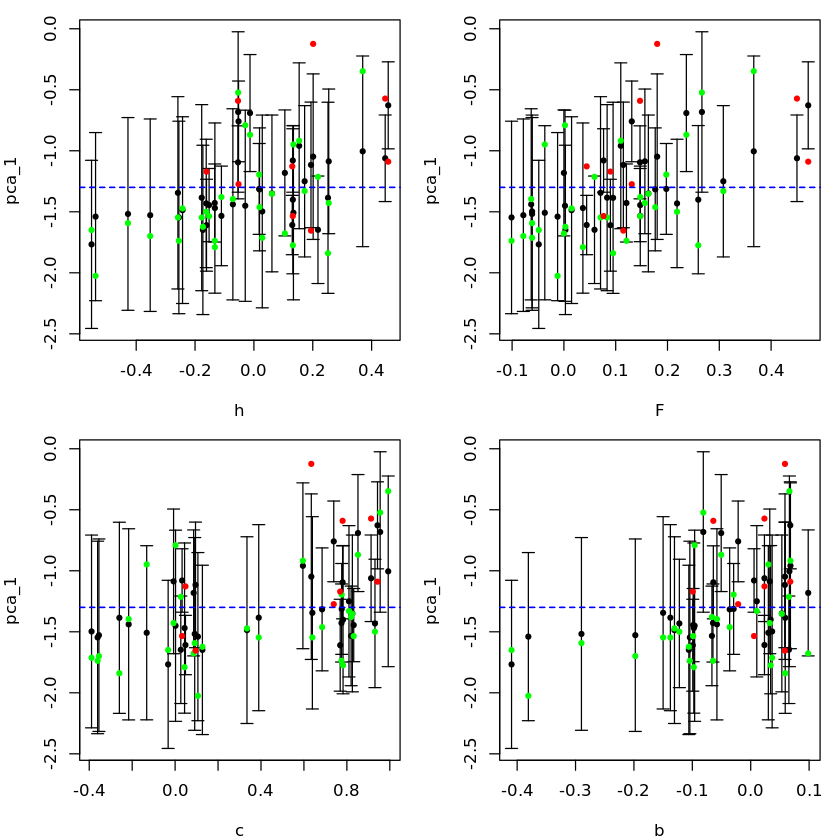

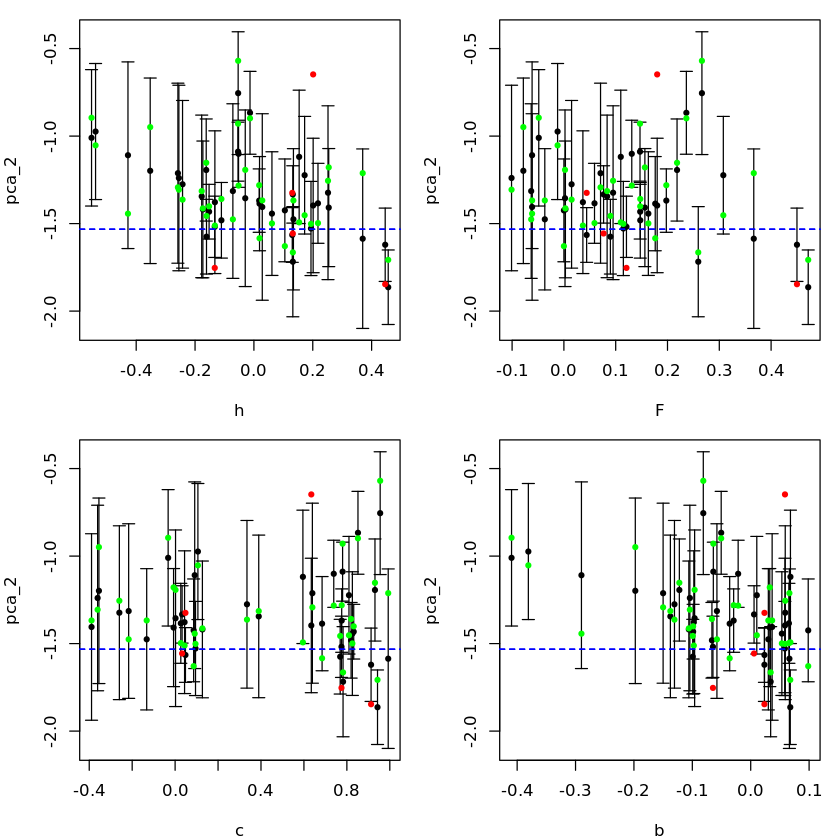

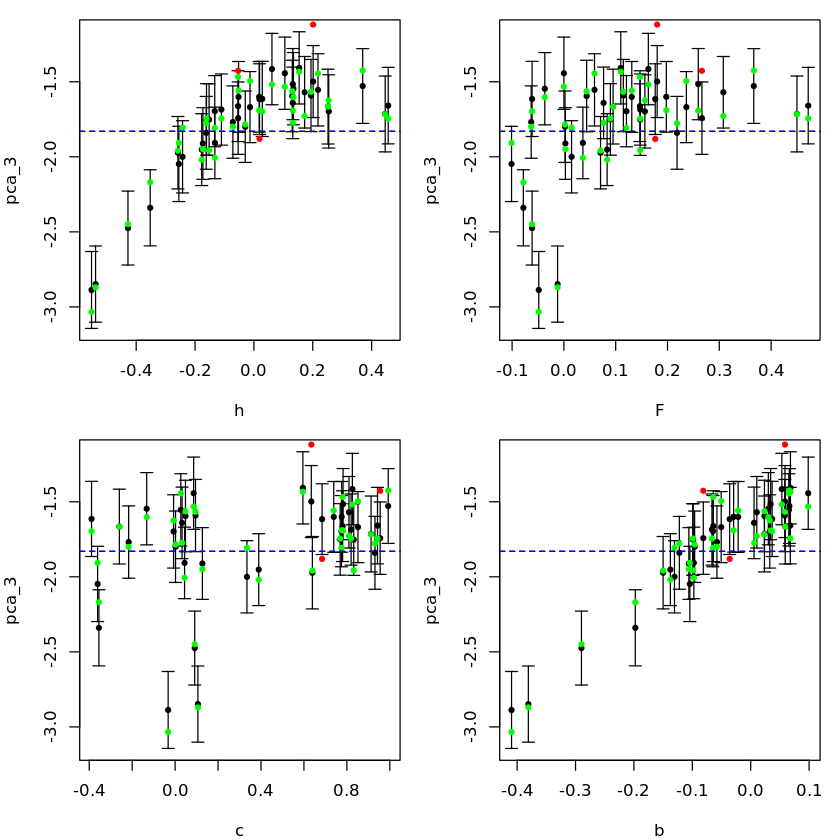

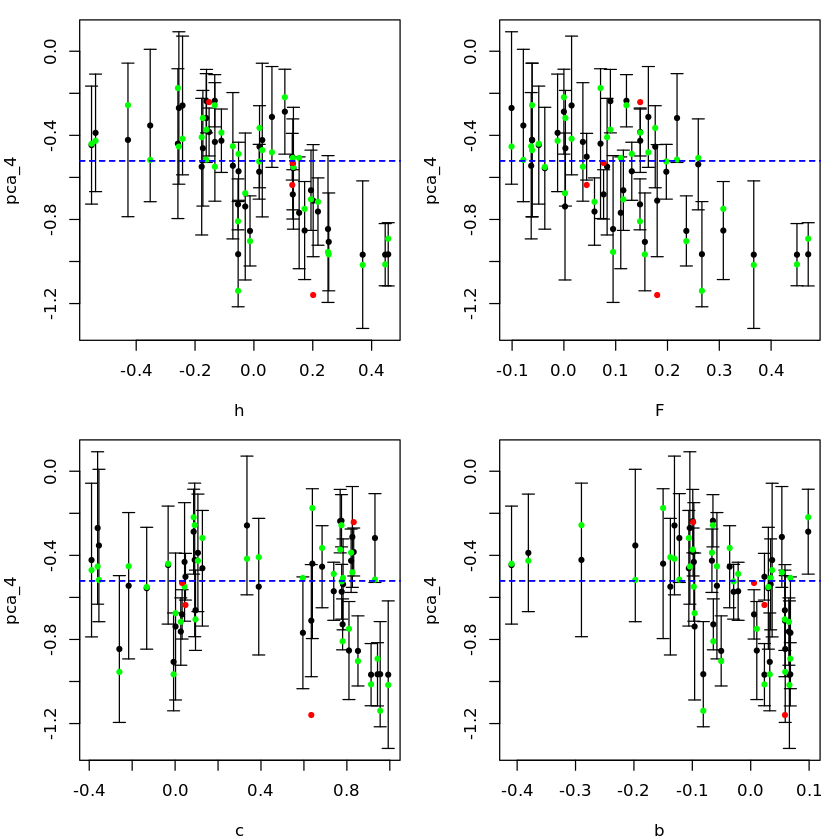

In [64]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [65]:
Timps5 <- matrix(rep(t(Timps4),1), ncol=ncol(Timps4), byrow=TRUE)
system.time(Timps5[NROY4,] <- ImplausibilityMOGP(NewData=Xp[NROY4,], Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.916   4.256   1.589 

In [66]:
ImpData_wave5 = cbind(Xp, Timps5)

In [67]:
valmax5 = 0 #how many outputs can be above the implausibility cut off?
ImpListM5 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave5, nEms=TestEm5$mogp$n_emulators, whichMax=valmax4+1)
NROY5 <- which(rowSums(Timps5 <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax5)
ratio5 <- length(NROY5)/dim(Xp)[1]
ratio5

[1] 0.000183

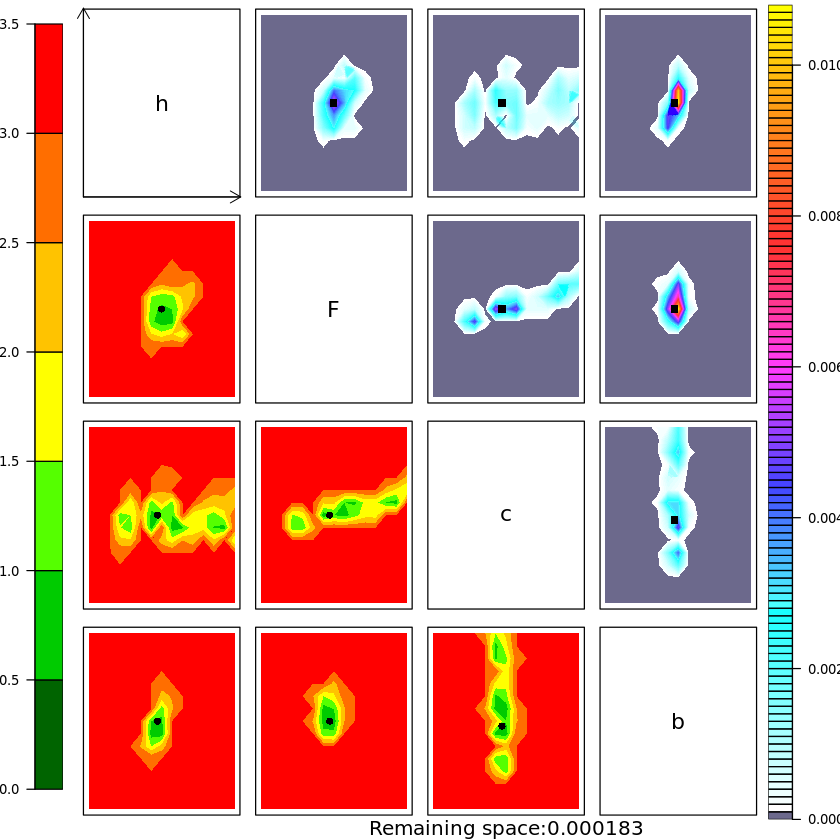

In [68]:
imp.layoutm11(ImpListM5,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY5)/dim(Xp)[1],sep=""), side=1)

In [69]:
length(NROY5)

[1] 183

## wave 6

In [83]:
40/ratio5

[1] 218579.2

In [84]:
set.seed(42)

designpoints5 <- data.frame()

############ SWITCH TO RANDOM LHS because it takes so much time !!!!!! ####################

while (nrow(designpoints5) < 40) {
        ### Emulator wave 1
        tmp <- as.data.frame(2*randomLHS(ceil(40/ratio5), 4)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        ### Emulator wave 4
        imps_tmp4 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp4 <- which(rowSums(imps_tmp4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax)
        ### Emulator wave 5
        imps_tmp5 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,], Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp5 <- which(rowSums(imps_tmp5 <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,][NROYtmp5,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints5 <- rbind(designpoints5,selectionP)
        print(nrow(designpoints5))
        flush.console()
        } 

designpoints5 <- designpoints5[sample(nrow(designpoints5),40),]

designpoints_denorm5 <- rangeUnscale(designpoints5, my_bounds)

[1] 41


In [85]:
write.csv(designpoints_denorm5,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave6.csv", row.names = FALSE)

In [86]:
inputs <- designpoints5

#Load outputs and select variables you want to keep
outputs <- read.csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave6.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,F,c,b,Noise,pca_0,pca_1,pca_2,pca_3,pca_4
3,-0.12340303,-0.135658472,-0.38813000,-0.087881309,0.68547922,1.253587,-0.9290304,-1.283630,-1.875317,-0.5041901
1,0.07007900,0.153010031,0.68676617,0.004170987,-0.28234909,2.912566,-1.4103367,-1.697310,-1.821587,-0.2578540
34,-0.28000122,-0.007186529,0.18683788,-0.144946691,0.18156421,1.818558,-1.7992808,-1.338281,-1.949876,-0.2913405
29,0.15569196,0.232527227,0.83865183,0.030236544,0.31643130,2.674127,-1.1418400,-1.518828,-1.636623,-0.4921809
12,-0.08626144,0.013670652,0.02476969,-0.065513491,0.20213416,3.027189,-1.7288572,-1.555684,-1.968067,-0.4077188
39,0.22173394,0.325991019,0.94283488,0.015134534,-0.05306226,3.822162,-1.0032599,-1.602630,-1.774543,-0.6480055


In [87]:
TestEm6 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:4])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.109700676579271 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = pca_0 ~ h, data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.72933 -0.68819  0.08652  0.67095  1.45728 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.4829     0.1361  18.239  < 2e-16 ***
h             3.0784     0.9033   3.408  0.00156 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8577 on 38 degrees of freedom
Multiple R-squared:  0.2341,	Adjusted R-squared:  0.2139 
F-statistic: 11.61 on 1 and 38 DF,  p-value: 0.001561

[1] "Max reduction is 0.0281773349337393 using F"
[1] "Max reduction is 0.0242460231621635 using F"
[1] "Max reduction is 0.0152808739799115 using b"
[1] "Max reduction is 0.103202503366322 using h"
[1] "Max reduction is 0.08521864374879 using c"
[1] "Max reduction is 0.0262328975795403 using Three Way Interactions with F"
[1] "Max reduction is 0.

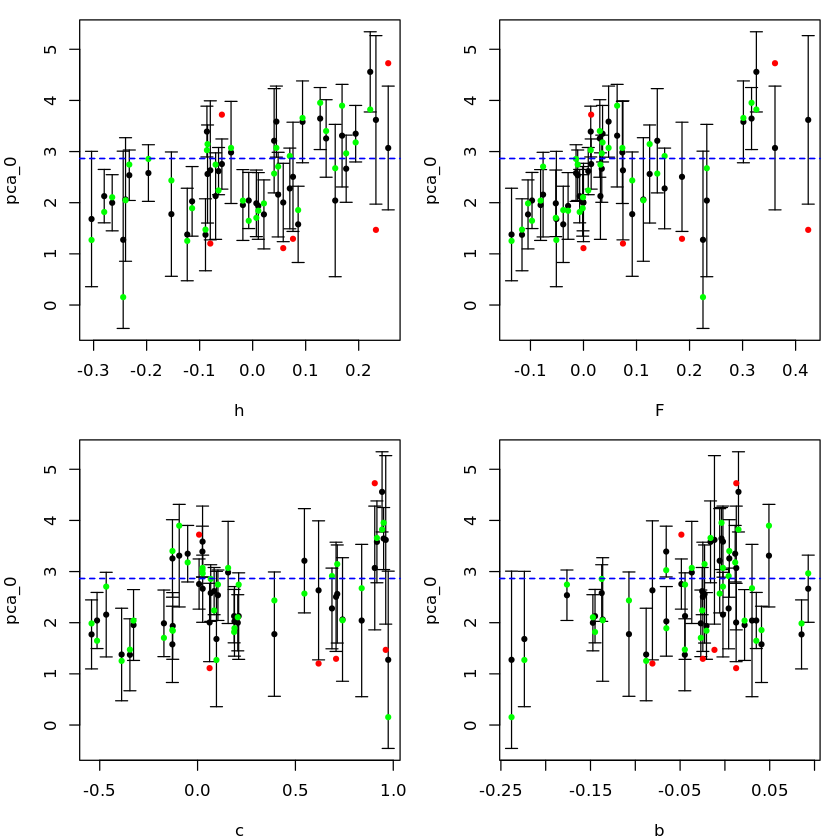

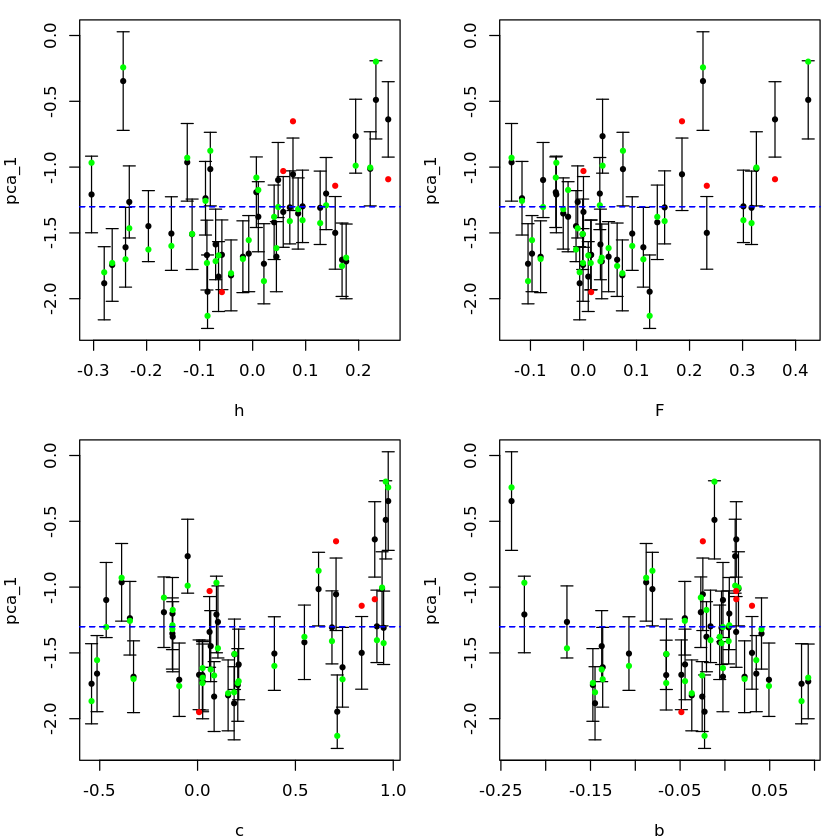

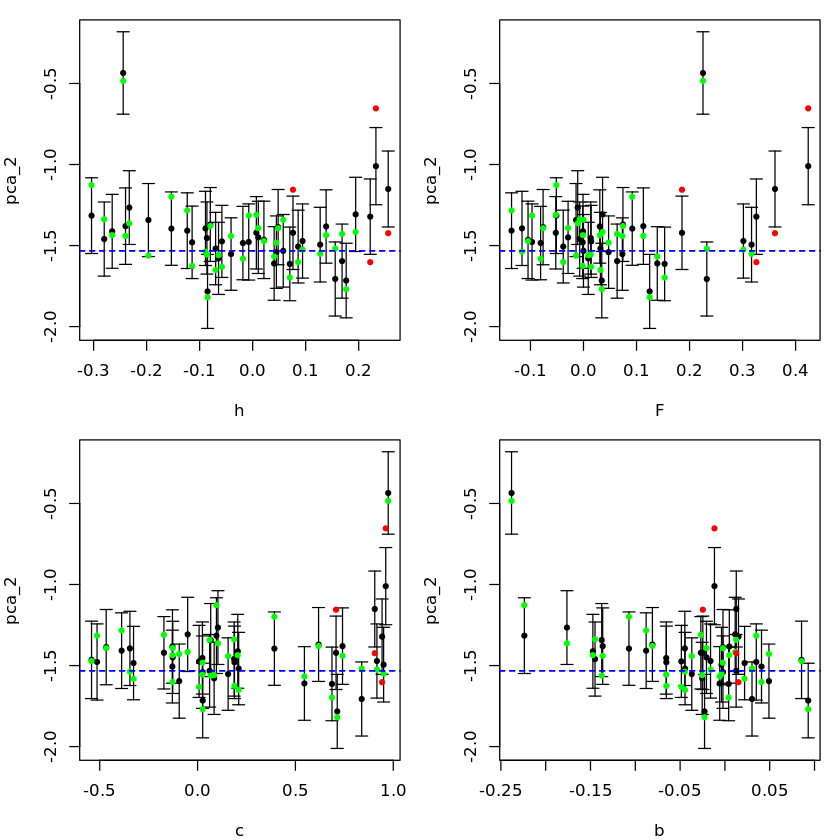

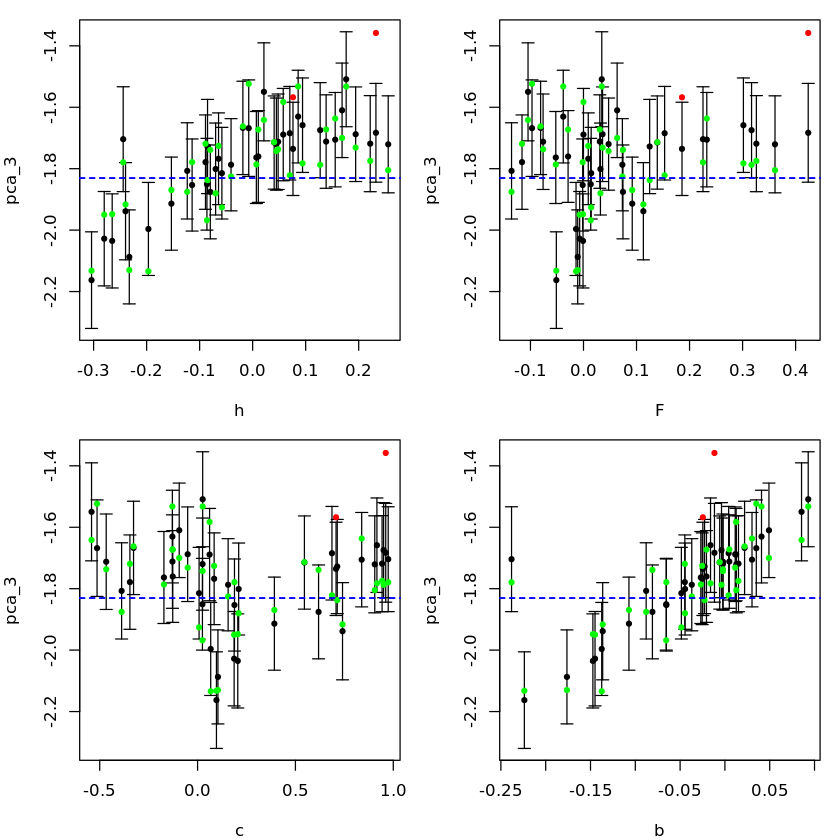

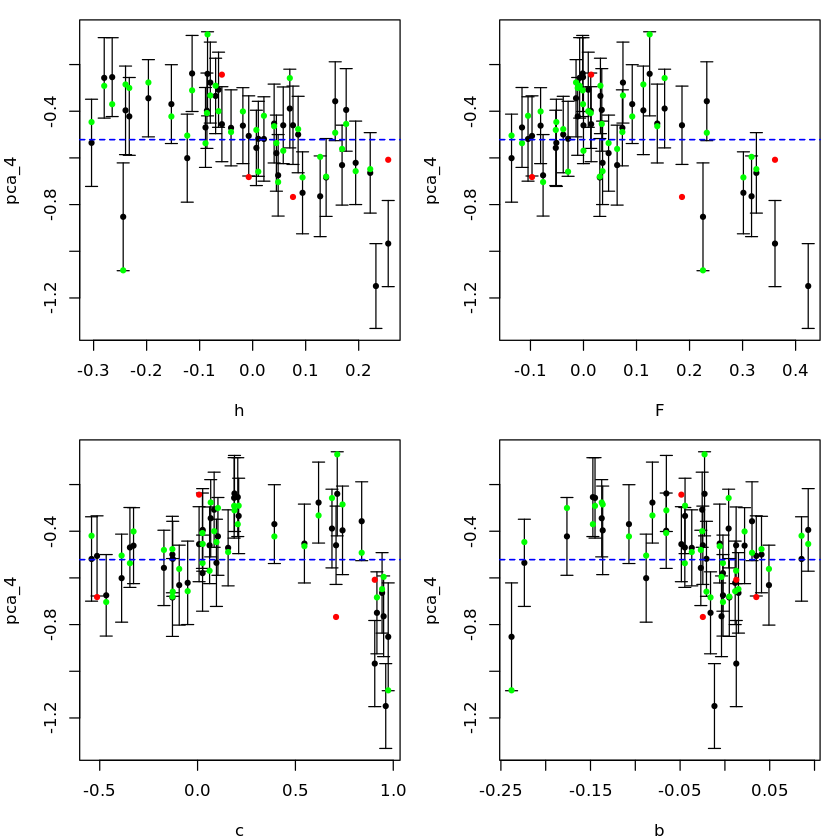

In [88]:
cands <- names(tData)[1:4]
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 1, ParamNames = cands, Obs = tObs2[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 2, ParamNames = cands, Obs = tObs2[2], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 3, ParamNames = cands, Obs = tObs2[3], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 4, ParamNames = cands, Obs = tObs2[4], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm6, which.emulator = 5, ParamNames = cands, Obs = tObs2[5], ObsErr = 0.)#tLOOs <- 

In [89]:
Timps6 <- matrix(rep(t(Timps5),1), ncol=ncol(Timps5), byrow=TRUE)
system.time(Timps6[NROY5,] <- ImplausibilityMOGP(NewData=Xp[NROY5,], Emulator=TestEm6, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.823   4.984   2.057 

In [90]:
ImpData_wave6 = cbind(Xp, Timps6)

In [91]:
valmax6 = 0 #how many outputs can be above the implausibility cut off?
ImpListM6 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave6, nEms=TestEm6$mogp$n_emulators, whichMax=valmax6+1)
NROY6 <- which(rowSums(Timps6 <= cutoff_vec[1]) >= TestEm6$mogp$n_emulators -valmax6)
ratio6 <- length(NROY6)/dim(Xp)[1]
ratio6

[1] 7.5e-05

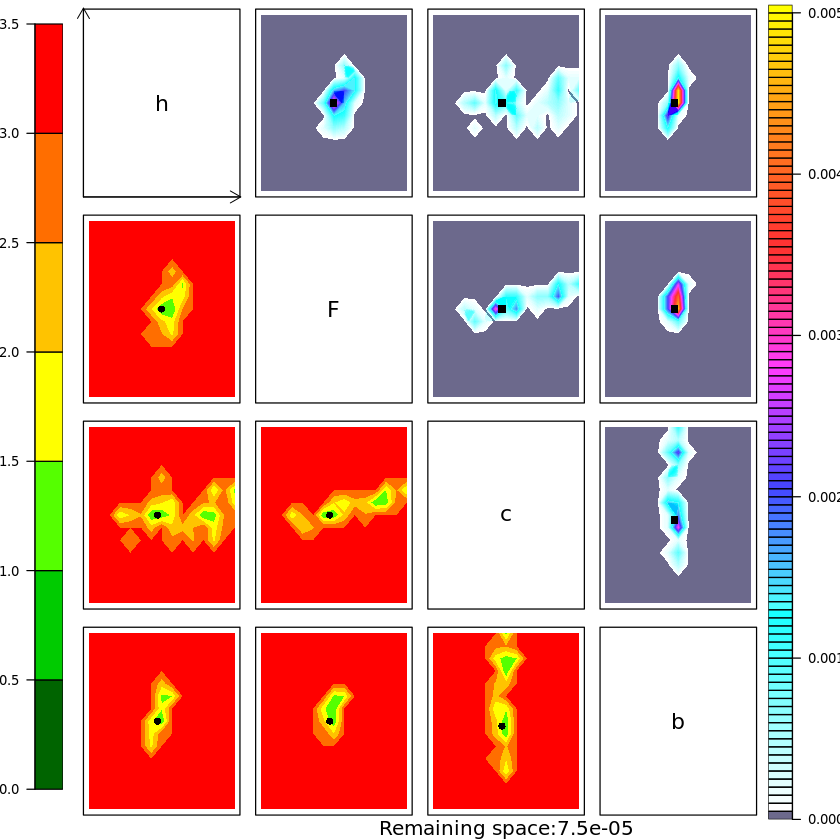

In [92]:
imp.layoutm11(ImpListM6,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY6)/dim(Xp)[1],sep=""), side=1)

In [93]:
length(NROY6)

[1] 75

In [96]:
colMeans(rangeUnscale(Xp[NROY6,], my_bounds))

h        F        c        b 
 1.04244 10.87491 12.71549 10.23945

## K-means

In [70]:
library(ClusterR)

Warning message:
“package ‘ClusterR’ was built under R version 3.6.3”Loading required package: gtools
Warning message:
“package ‘gtools’ was built under R version 3.6.3”
Attaching package: ‘gtools’

The following object is masked from ‘package:pracma’:

    logit



In [71]:
preProcValues <- preProcess(Xp[NROY5,], method = c("center", "scale"))
normalizeddata <- predict(preProcValues, Xp[NROY5,])

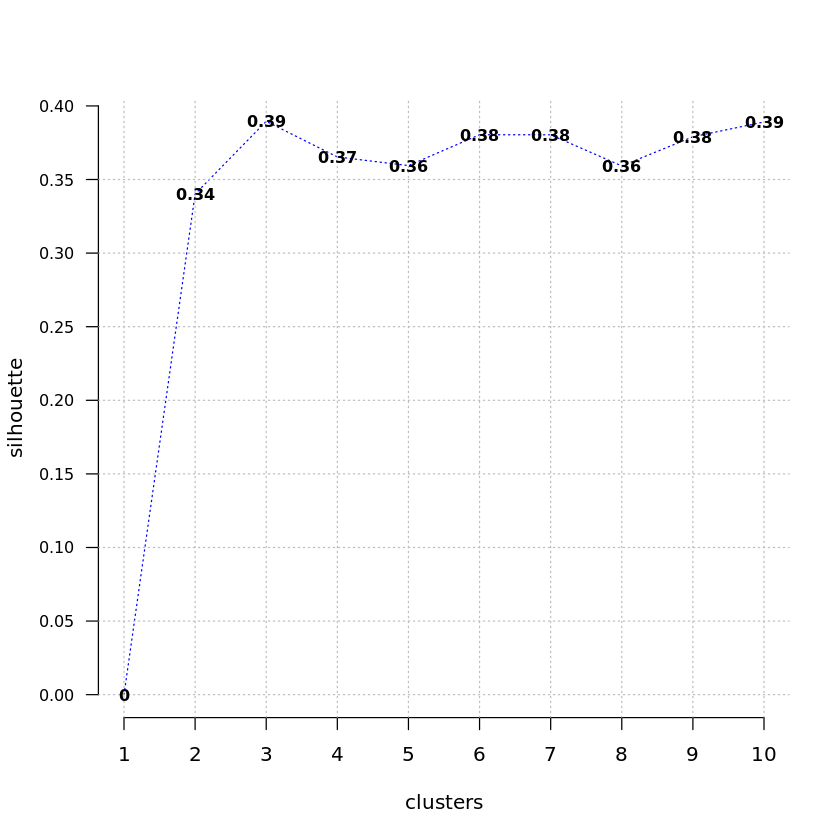

In [72]:
opt_km = Optimal_Clusters_KMeans(normalizeddata, 
                                 criterion = "silhouette", 
                                 max_clusters=10,
                                 plot_clusters = TRUE)

In [73]:
classif <- kmeans(normalizeddata, centers=3, iter.max=100, nstart=100)
kmcenters <- unPreProc(preProcValues, data.frame(classif$centers))
candidates <- rangeUnscale(kmcenters, my_bounds)
candidates

h,F,c,b
1.0532221,9.867436,9.056659,10.520146
0.8074277,10.062773,11.458736,9.295226
1.1107144,12.130353,17.100514,10.480709


In [74]:
nrow(rangeUnscale(unPreProc(preProcValues, normalizeddata[classif$cluster==1,]), my_bounds))

[1] 79

In [75]:
library(xtable)

print.xtable(xtable(candidates))


Attaching package: ‘xtable’

The following object is masked from ‘package:spam’:

    display



% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Thu Feb 17 16:32:55 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & h & F & c & b \\ 
  \hline
1 & 1.05 & 9.87 & 9.06 & 10.52 \\ 
  2 & 0.81 & 10.06 & 11.46 & 9.30 \\ 
  3 & 1.11 & 12.13 & 17.10 & 10.48 \\ 
   \hline
\end{tabular}
\end{table}


# Ensemble of plausible simulations

In [76]:
### check if Kmeans centers are in NROY6
imps_kmeans <- ImplausibilityMOGP(NewData=kmcenters, Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
which(rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax5)

[1] 1 2 3

In [77]:
testpoints <- rangeUnscale(kmcenters, my_bounds)[rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax5,]

In [78]:
write.csv(testpoints,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA_PhysPrior.csv", row.names = FALSE)

## summary of the HM

In [79]:
NROYs <- 100 * c(ratio1, ratio2, ratio3, ratio4, ratio5)
NbSim <- c(40, nrow(designpoints), nrow(designpoints2), nrow(designpoints3), nrow(designpoints4))

In [80]:
data.frame(NROYs, NbSim)

NROYs,NbSim
25.5731,40
3.1812,40
0.5890,40
0.0379,40
0.0183,40


In [81]:
print.xtable(xtable(data.frame(NROYs, NbSim)))

% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Thu Feb 17 16:33:15 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & NROYs & NbSim \\ 
  \hline
1 & 25.57 & 40.00 \\ 
  2 & 3.18 & 40.00 \\ 
  3 & 0.59 & 40.00 \\ 
  4 & 0.04 & 40.00 \\ 
  5 & 0.02 & 40.00 \\ 
   \hline
\end{tabular}
\end{table}


In [82]:
sum(NbSim)

[1] 200